"""
Ê¨Ñ‰ΩçÁµêÊßãË™™ÊòéÔºåÊï¥Âêà‰∏âÂπ≥Âè∞Áî®
unified_columns = [
    'system_id',    # keyÂÄº
    'dataSource',   # Âπ≥Âè∞‰æÜÊ∫êÔºàYT/PTT/IGÔºâ
    'artUrl',       # ÂÖßÂÆπÈÄ£Áµê
    'artDate',      # ÁôºÂ∏ÉÊôÇÈñìÔºàÁµ±‰∏ÄÊ†ºÂºèÔºâ
    'artTitle',     # Ê®ôÈ°å
    'artContent',   # ÂÖßÂÆπÊñáÂ≠ó
    'artPoster',    # ‰ΩúËÄÖ/ÁôºÂ∏ÉËÄÖ
    'artPosterUrl', # ‰ΩúËÄÖÈÄ£Áµê
    'comments',     # Ë©ïË´ñÂÖßÂÆπ
    'commentcount', # Ë©ïË´ñÊï∏Èáè
    'likecount',    # ÈªûËÆöÊï∏
    'category',     # ÂàÜÈ°û/ÁâàÈù¢/È°ûÂûã
    'media_type'    # Â™íÈ´îÈ°ûÂûãÔºàÂΩ±Áâá/ÂúñÁâá/ÊñáÂ≠ó/Ê∑∑ÂêàÔºâ
]
"""

0.Â∞éÂÖ•ÂøÖË¶ÅÁöÑÂ•ó‰ª∂

In [1]:
# Âü∫Êú¨Ë≥áÊñôËôïÁêÜ
import os, re
from datetime import datetime
from collections import Counter, namedtuple, defaultdict
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple, Set
from math import log

# ÊñáÂ≠óËôïÁêÜËàá NLP
import jieba, jieba.posseg as pseg, jieba.analyse
from snownlp import SnowNLP
from nltk import ngrams, FreqDist
from gensim import corpora, models
from wordcloud import WordCloud

# Ê©üÂô®Â≠∏Áøí
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE  # Áî®ÊñºÈôçÁ∂≠ÂèØË¶ñÂåñ
from sklearn.model_selection import train_test_split

# Ë¶ñË¶∫Âåñ
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px

# Áπ™ÂúñË®≠ÂÆö
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

# Ë®≠ÂÆöÁπ™ÂúñÁí∞Â¢É
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')


1. Ë≥áÊñôËÆÄÂèñËàáÊï¥Âêà

In [39]:
# ËÆÄÂèñ‰∏âÂπ≥Âè∞Ë≥áÊñô
yt = pd.read_csv('chiikawa_data/chiikawa_yt_data.csv')
ptt = pd.read_csv('chiikawa_data/chiikawa_ptt_data.csv')
ig = pd.read_csv('chiikawa_data/chiikawa_ig_data.csv')

# Ê¨Ñ‰ΩçÁµ±‰∏ÄËàáË£úÈΩä
yt_df = pd.DataFrame({
    'system_id': yt['system_id'],
    'dataSource': yt['dataSource'],
    'artUrl': yt['artUrl'],
    'artDate': pd.to_datetime(yt['artDate']),
    'artTitle': yt['artTitle'],
    'artContent': yt['artContent'],
    'artPoster': yt['artPoster'],
    'artPosterUrl': yt['artPosterUrl'],
    'commentcount': yt['commentcount'],
    'likecount': yt['likecount'],
    'category': ''  # YouTubeÁÑ°ÂàÜÈ°û
})

ptt_df = pd.DataFrame({
    'system_id': ptt['system_id'],
    'dataSource': ptt['dataSource'],
    'artUrl': ptt['artUrl'],
    'artDate': pd.to_datetime(ptt['artDate']),
    'artTitle': ptt['artTitle'],
    'artContent': ptt['artContent'],
    'artPoster': ptt['artPoster'],
    'artPosterUrl': '',  # ÁÑ°Ê≠§Ê¨Ñ
    'commentcount': ptt['artComment'].apply(lambda x: x.count('Êé®') + x.count('Âôì') + x.count('‚Üí') if pd.notna(x) else 0),
    'likecount': 0,  # ÁÑ°likeÊï∏ÔºåË¶ÅÁî®commentcountÂéªÁÆó
    'category': ptt['artCatagory']
})

ig_df = pd.DataFrame({
    'system_id': ig['system_id'],
    'dataSource': ig['dataSource'],
    'artUrl': ig['artUrl'],
    'artDate': pd.to_datetime(ig['artDate']),
    'artTitle': '',  # IGÁÑ°Ê®ôÈ°å
    'artContent': ig['artContent'],
    'artPoster': ig['artPoster'],
    'artPosterUrl': ig['artPosterUrl'],
    'commentcount': ig['commentcount'],
    'likecount': ig['likecount'],
    'category': ig['type']
})

# Âêà‰ΩµË≥áÊñô‰∏¶Áµ±‰∏ÄË≥áÊñôÊ†ºÂºèÔºåË™øÊï¥Áº∫Â§±Ê¨Ñ‰Ωç
df = pd.concat([yt_df, ptt_df, ig_df], ignore_index=True)

# ÊôÇÈñìÊ†ºÂºèÁµ±‰∏Ä
df['artDate'] = df['artDate'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Áº∫Â§±ÂÄºËôïÁêÜ
df.fillna('', inplace=True)

# ÂÑ≤Â≠òÊàê‰∏ÄÂÄãÁµ±‰∏ÄÊ†ºÂºèÔºåÂéüÂßãÊ™îÊ°àÊúâÊì¥ÂÖÖÂèØÈö®ÊôÇÊõ¥Êñ∞
df.to_csv('chiikawa_unified_data.csv', index=False, encoding='utf-8-sig')

# Ê™¢Ë¶ñÂêà‰ΩµÂæåÁöÑË≥áÊñô
# print(f"Âêà‰ΩµÂæåË≥áÊñôÁ≠ÜÊï∏: {len(df)}")
# print(f"Ë≥áÊñôÊ¨Ñ‰Ωç: {df.columns.tolist()}")
# print(f"Ë≥áÊñôÊ®£Êú¨:\n{df.head(3)}")

2. Ë≥áÊñôÈ†êËôïÁêÜËàáÊñáÊú¨Ê∏ÖÁêÜ

In [40]:
# Â∞çÊñáÊú¨ÈÄ≤Ë°åÂÆåÊï¥ÁöÑÊ∏ÖÁêÜ
df['clean_content'] = df['artContent'].astype(str)
# Â∞áÂ§öÂÄãÈÄ£Á∫åÊèõË°åÁ¨¶ÊõøÊèõÁÇ∫Âè•Ëôü
df['clean_content'] = df['clean_content'].str.replace(r'\n\n', '„ÄÇ', regex=True)
# Â∞áÂñÆÂÄãÊèõË°åÁ¨¶ÊõøÊèõÁÇ∫ÈÄóËôü
df['clean_content'] = df['clean_content'].str.replace(r'\n', 'Ôºå', regex=True)
# ÁßªÈô§Á∂≤ÂùÄ
df['clean_content'] = df['clean_content'].str.replace(r'http\S+', '', regex=True).str.replace(r'www\S+', '', regex=True)
# Áµ±‰∏ÄÊ®ôÈªûÁ¨¶ËôüÔºåÁßªÈô§Ë°®ÊÉÖÁ¨¶ËôüÂíåÁâπÊÆäÁ¨¶Ëôü
df['clean_content'] = df['clean_content'].str.replace(r'[^\u4e00-\u9fff\s.,!?;:„ÄÅÔºå„ÄÇÔºÅÔºüÔºõÔºö]', '', regex=True)

# ‰ΩøÁî®Ê≠£ÂâáË°®ÈÅîÂºèÈÄ≤Ë°åÊõ¥Á≤æÁ¢∫ÁöÑÊñ∑Âè•
def split_sentences(text):
    # ‰ª•Âè•Ëôü„ÄÅÂïèËôü„ÄÅÊÑüÂòÜËôüÁ≠â‰ΩúÁÇ∫Êñ∑Âè•Ê®ôË®ò
    sentences = re.split(r'[„ÄÇÔºÅÔºü!?]+', text)
    # ÁßªÈô§Á©∫Â≠óÁ¨¶‰∏≤ÂíåÂè™ÂåÖÂê´Á©∫ÁôΩÁöÑÂ≠óÁ¨¶‰∏≤
    return [s.strip() for s in sentences if s.strip()]

df['sentences'] = df['clean_content'].apply(split_sentences)

# Ê™¢Ë¶ñÊñ∑Âè•ÁµêÊûú
sample_sentences = df[df['sentences'].str.len() > 0].iloc[0]['sentences']
print(f"Êñ∑Âè•ÁØÑ‰æãÔºö{sample_sentences[:3]}")  # È°ØÁ§∫Ââç3ÂÄãÂè•Â≠ê

Êñ∑Âè•ÁØÑ‰æãÔºö['Â∞èÂÖ´Ë∑≥Ëàû Âêâ‰ºäÂç°Âìá']


3. Ë®≠ÂÆöÊñ∑Ë©ûÂºïÊìéÂíåÂ≠óÂÖ∏-ÂÅúÁî®Ë©ûË®≠ÂÆö

In [41]:
# Ë®≠ÂÆöjiebaÁöÑÂ≠óÂÖ∏Âíå‰ΩøÁî®ËÄÖËá™ÂÆöÁæ©Ë©ûÂÖ∏
jieba.set_dictionary('dict/dict.txt.big')  # ‰ΩøÁî®ÁπÅÈ´î‰∏≠ÊñáÂ≠óÂÖ∏

# Êñ∞Â¢ûÁâπÂÆöÈ†òÂüüË©ûÂΩôÂà∞Ëá™ÂÆöÁæ©Ë©ûÂÖ∏
custom_words = [
    # ‰∏ªË¶ÅÂêçÁ®±
    "Chiikawa", "Âêâ‰ºäÂç°Âìá", "„Å°„ÅÑ„Åã„Çè", "Âêâ‰ºä", "Â∞èÂèØÊÑõ", "Âêâ‰æù", "ÂØ∂ÂØ∂",
    
    # ‰∏ªË¶ÅËßíËâ≤
    "Â∞èÂÖ´Ë≤ì", "„Éè„ÉÅ„ÉØ„É¨", "Hachiware", "ÂÖ´Â≠óÁÄèÊµ∑", "Â∞èÂÖ´", "ËóçËâ≤Ë§≤È†≠Ë≤ì", "ÂìàÂ•á" , "ÂìàÂêâ",
    "ÂÖîÂÖî", "„ÅÜ„Åï„Åé", "Usagi", "ÁÉèËñ©Â•á", "ÂÖîÂì•", "537",
    "Â∞èÊ°É", "„É¢„É¢„É≥„Ç¨", "Momonga", "È£õÈº†",
    "Êµ∑Áç∫ÂãáËÄÖ", "„É©„ÉÉ„Ç≥", "Rakko",
    "Ê†óÂ≠êÈ•ÖÈ†≠", "„Åè„Çä„Åæ„Çì„Åò„ÇÖ„ÅÜ", "Kuri-Manjuu", "ÂâçËº©",
    
    # ÂÖ∂‰ªñËßíËâ≤
    "È¢®ÁçÖ", "„Ç∑„Éº„Çµ„Éº", "Shisa", "ÁçÖËñ©",
    "ÊãâÈ∫µÈéßÁî≤‰∫∫", "ÊâãÊãøÂåÖÈéßÁî≤‰∫∫", "ÂãûÂãïÈéßÁî≤‰∫∫", "ÈéßÁî≤‰∫∫",
    "Áù°Ë°£Ê¥æÂ∞ç", "„Éë„Ç∏„É£„Éû„Éë„Éº„ÉÜ„Ç£„Éº„Ç∫", "Âì•Â∏ÉÊûó",
    
    # ÁâπÊÆäË©ûÂΩô
    "Âêâ‰ºäÂç°ÂìáÊßãÊñá", "Èô§ËçâËÄÉË©¶", "Èô§ËçâÊ™¢ÂÆö", "Â∞èÂèØÊÑõÊóè",
    "ÈÉéÊãâÈ∫µÂ∫ó", "‰∏âÁ¥öÈô§ËçâË≠â‰ª∂", "Ë®é‰ºê", "ÊäΩÁçéÈÅã",
    
    # ÁâπÊÄßÊèèËø∞
    "ËÜΩÂ∞èÈ¨º", "ÊÑõÂì≠È¨º", "ÁôÇÁôí", "‰∫åÈ†≠Ë∫´", "ÂïäÂìà", "ÂêñÂìà",
    "ÂèàÂ∞èÂèàÂèØÊÑõ", "„Å™„Çì„ÅãÂ∞è„Åï„Åè„Å¶„Åã„Çè„ÅÑ„ÅÑ„ÇÑ„Å§",
    
    # Ââµ‰ΩúÁõ∏Èóú
    "Nagano", "„Éä„Ç¨„Éé", "ÂãïÁï´Â∑•Êàø", "Âë®ÈÇäÂïÜÂìÅ", "Ë≤ºÂúñ", "‰∏ÄÁï™Ë≥û"
]

for word in custom_words:
    jieba.add_word(word, freq=100)  # Áµ¶‰∫àËºÉÈ´òË©ûÈ†ª‰ª•Á¢∫‰øùËÉΩË¢´ÂàáÂàÜÂá∫‰æÜ

# Âª∫Á´ãËßíËâ≤ÂêåÁæ©Ë©ûÊò†Â∞ÑË°®
character_synonyms = {
    # ‰∏ªËßíÂêåÁæ©Ë©ûÊò†Â∞Ñ
    "„Å°„ÅÑ„Åã„Çè": "Âêâ‰ºäÂç°Âìá", "Chiikawa": "Âêâ‰ºäÂç°Âìá", "Âêâ‰ºä": "Âêâ‰ºäÂç°Âìá", 
    "Â∞èÂèØÊÑõ": "Âêâ‰ºäÂç°Âìá", "Âêâ‰æù": "Âêâ‰ºäÂç°Âìá",
    
    # Â∞èÂÖ´Ë≤ìÂêåÁæ©Ë©ûÊò†Â∞Ñ
    "„Éè„ÉÅ„ÉØ„É¨": "Â∞èÂÖ´Ë≤ì", "Hachiware": "Â∞èÂÖ´Ë≤ì", "ÂÖ´Â≠óÁÄèÊµ∑": "Â∞èÂÖ´Ë≤ì", 
    "Â∞èÂÖ´": "Â∞èÂÖ´Ë≤ì", "ËóçËâ≤Ë§≤È†≠Ë≤ì": "Â∞èÂÖ´Ë≤ì", "ÂìàÂ•á": "Â∞èÂÖ´Ë≤ì", "ÂìàÂêâ": "Â∞èÂÖ´Ë≤ì",
    
    # ÂÖîÂÖîÂêåÁæ©Ë©ûÊò†Â∞Ñ
    "„ÅÜ„Åï„Åé": "ÂÖîÂÖî", "Usagi": "ÂÖîÂÖî", "ÁÉèËñ©Â•á": "ÂÖîÂÖî", 
    "ÂÖîÂì•": "ÂÖîÂÖî", "537": "ÂÖîÂÖî",
    
    # ÂÖ∂‰ªñËßíËâ≤ÂêåÁæ©Ë©ûÊò†Â∞Ñ
    "„É¢„É¢„É≥„Ç¨": "Â∞èÊ°É", "Momonga": "Â∞èÊ°É", "È£õÈº†": "Â∞èÊ°É",
    "„É©„ÉÉ„Ç≥": "Êµ∑Áç∫ÂãáËÄÖ", "Rakko": "Êµ∑Áç∫ÂãáËÄÖ",
    "„Åè„Çä„Åæ„Çì„Åò„ÇÖ„ÅÜ": "Ê†óÂ≠êÈ•ÖÈ†≠", "Kuri-Manjuu": "Ê†óÂ≠êÈ•ÖÈ†≠", "ÂâçËº©": "Ê†óÂ≠êÈ•ÖÈ†≠",
    "„Ç∑„Éº„Çµ„Éº": "È¢®ÁçÖ", "Shisa": "È¢®ÁçÖ", "ÁçÖËñ©": "È¢®ÁçÖ",
    "„Éë„Ç∏„É£„Éû„Éë„Éº„ÉÜ„Ç£„Éº„Ç∫": "Áù°Ë°£Ê¥æÂ∞ç", "Âì•Â∏ÉÊûó": "Áù°Ë°£Ê¥æÂ∞ç"
}

# ËºâÂÖ•ÂÅúÁî®Ë©û
def load_stopwords(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            stopwords = [line.strip() for line in f.readlines()]
        return set(stopwords)
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='big5') as f:
            stopwords = [line.strip() for line in f.readlines()]
        return set(stopwords)
    except Exception as e:
        print(f"ËÆÄÂèñÂÅúÁî®Ë©ûÊ™îÊ°àÊôÇÁôºÁîüÈåØË™§: {e}")
        return set()

# ËÆÄÂèñÂÅúÁî®Ë©û
stopwords_path = "./dict/stopwords.txt"  
stopwords = load_stopwords(stopwords_path)
print(f"Â∑≤ËºâÂÖ• {len(stopwords)} ÂÄãÂÅúÁî®Ë©û")

# Êñ∞Â¢ûËá™ÂÆöÁæ©ÂÅúÁî®Ë©û
custom_stopwords = [
    # ‰ª£Ë©û
    "Êàë", "‰Ω†", "‰ªñ", "Â•π", "ÂÆÉ", "ÊàëÂÄë", "‰Ω†ÂÄë", "‰ªñÂÄë", "Â•πÂÄë", "ÂÆÉÂÄë", "ÈÄô", "ÈÇ£", "ÈÄô‰∫õ", "ÈÇ£‰∫õ", "Ë™∞", "‰ªÄÈ∫º", "Âì™", "Âì™Ë£°", "Âì™ÂÖí", "ÊÄéÈ∫º", "ÊÄéÊ®£", "Â¶Ç‰Ωï",
    
    # ÈÄ£Êé•Ë©û
    "Âíå", "Ëàá", "ËÄå", "‰∏¶", "Êàñ", "‰ΩÜ", "‰ΩÜÊòØ", "ÁÑ∂ËÄå", "ÊâÄ‰ª•", "Âõ†ÁÇ∫", "Âõ†Ê≠§", "Â¶ÇÊûú", "ÈõñÁÑ∂", "Âç≥‰Ωø", "ÁÑ°Ë´ñ", "Âè™Ë¶Å", "‰∏çË´ñ", "ÂÅáÂ¶Ç", "Ëã•", "Ëã•ÊòØ",
    
    # Âä©Ë©û
    "ÁöÑ", "Âú∞", "Âæó", "‰∫Ü", "Ëëó", "ÈÅé", "Âêß", "Âóé", "Âë¢", "Âïä", "Âì¶", "Âñî", "ÂëÄ", "ËÄ∂", "Âìé", "Âîâ", "ÂóØ", "Âòø",
    
    # ÂâØË©û
    "Âæà", "ÈùûÂ∏∏", "Ê•µ", "Â§™", "Êõ¥", "ÊúÄ", "Âèà", "‰πü", "ÈÉΩ", "ÈÇÑ", "Âè™", "Â∞±", "Êâç", "Ââõ", "Êõæ", "Â∑≤", "Â∞á", "‰∏ç", "Ê≤í", "Âà•", "Ëé´", "Âãø",
    
    # ‰ªãË©û
    "Âú®", "Âæû", "Âêë", "ÂæÄ", "Êñº", "Â∞ç", "Áµ¶", "ÁÇ∫", "Êõø", "Áî±", "Êää", "Ë¢´", "ËÆì", "‰Ωø", "Èö®", "Ë∑ü", "Èù†", "Êìö", "Ëá≥", "Âà∞", "Ëá™",
    
    # Êï∏ÈáèË©û
    "‰∏Ä", "‰∫å", "‰∏â", "Âõõ", "‰∫î", "ÂÖ≠", "‰∏É", "ÂÖ´", "‰πù", "ÂçÅ", "Áôæ", "ÂçÉ", "Ëê¨", "ÂÑÑ", "ÂÖÜ", "ÂÄã", "‰∫õ", "ÊØè", "Êüê", "ÂêÑ", "Êï¥", "ÂÖ®", "Â§ö", "Â∞ë", "Âπæ",
    
    # ÊôÇÈñìË©û
    "Âπ¥", "Êúà", "Êó•", "ÊôÇ", "ÂàÜ", "Áßí", "Â§©", "ÈÄ±", "Â≠£", "‰ªä", "Êò®", "Êòé", "Ââç", "Âæå", "Áï∂", "Ê≠£", "Áèæ", "Êõæ", "Â∑≤", "Â∞á", "ÊúÉ", "Â∏∏", "Ê∞∏",
    
    # Êñπ‰ΩçË©û
    "‰∏ä", "‰∏ã", "Â∑¶", "Âè≥", "Ââç", "Âæå", "ÂÖß", "Â§ñ", "‰∏≠", "Êù±", "Ë•ø", "Âçó", "Âåó", "‰∏≠Èñì", "ÊóÅÈÇä", "ÈôÑËøë", "Âë®Âúç",
    
    # Â∏∏Áî®ÂãïË©û
    "ÊòØ", "Êúâ", "ÁÑ°", "‰æÜ", "Âéª", "ÂÅö", "Áúã", "ËÅΩ", "Ë™™", "ÊÉ≥", "Ë¶Å", "ËÉΩ", "ÊúÉ", "ÂèØ‰ª•", "ÊáâË©≤", "ÂøÖÈ†à", "ÈúÄË¶Å", "Âæó", "Áç≤", "Âèñ", "‰∫à",
    
    # Â∏∏Áî®ÂΩ¢ÂÆπË©û
    "Â•Ω", "Â£û", "Â§ß", "Â∞è", "Â§ö", "Â∞ë", "È´ò", "‰Ωé", "Èï∑", "Áü≠", "Êñ∞", "Ëàä", "Âø´", "ÊÖ¢", "ÈÅ†", "Ëøë", "Ëºï", "Èáç", "Ê∑±", "Ê∑∫",
    
    # ÂÖ∂‰ªñÂ∏∏Ë¶ãËôõË©û
    "‰πã", "‰πé", "‰ª•", "ÂÖ∂", "ÊâÄ", "ËÄÖ", "Áü£", "ÁÑâ", "Âìâ", "‰πü", "ÁÑ∂", "Âê¶", "ÂÖÆ", "‰πÉ", "‰∏î", "ÁÇ∫", "Ââá", "ÂÜç", "Âèà", "Ê≠§", "Â§´", "‰∫¶",
    
    # Â∏∏Ë¶ãÁü≠Ë™û
    "‰∏ÄÂÄã", "ÈÄôÂÄã", "ÈÇ£ÂÄã", "‰∏Ä‰∫õ", "ÈÄô‰∫õ", "ÈÇ£‰∫õ", "‰∏Ä‰∏ã", "‰∏ÄÈªû", "‰∏ÄÁõ¥", "‰∏ÄÂÆö", "‰∏ÄËà¨", "‰∏ÄÊ®£", "‰∏çÈÅé", "‰∏çÂøÖ", "‰∏çË¶Å", "ÂèØËÉΩ", "ÂèØÊòØ", "Âè™ÊòØ", "Â∞±ÊòØ", "Â¶ÇÊ≠§", "Â¶ÇÊûú", "ÈÄôÊ®£", "ÈÇ£Ê®£", "ÈÄôÈ∫º", "ÈÇ£È∫º", "Âõ†Ê≠§", "ÊâÄ‰ª•", "ÁÑ∂Âæå", "Êé•Ëëó", "ÂÖ∂ÂØ¶", "ÂÖ∂‰∏≠", "ÂÖ∂‰ªñ", "ÂÖ∂ÂÆÉ", "‰πãÂâç", "‰πãÂæå", "‰πã‰∏≠", "‰πãÈñì",
    
    # Á∂≤Ë∑ØÁî®Ë™û
    "http", "www", "com", "cn", "org", "net", "html", "htm", "php", "jpg", "png", "gif", ".."
]
stopwords.update(custom_stopwords)



Building prefix dict from g:\ÊàëÁöÑÈõ≤Á´ØÁ°¨Á¢ü\I want to graduate I want to graduate\‰∫å‰∏ã\SMA\SMA_final\dict\dict.txt.big ...
Loading model from cache C:\Users\qqw12\AppData\Local\Temp\jieba.u5b75d4bc912d0a353138fdc294f176b2.cache
Loading model cost 1.123 seconds.
Prefix dict has been built successfully.


Â∑≤ËºâÂÖ• 1211 ÂÄãÂÅúÁî®Ë©û


4. Ë©ûÈ†ªÂàÜÊûê

In [42]:
# Âü∫ÊñºË©ûÈ†ªÂàÜÊûêÔºåË≠òÂà•ÈúÄË¶Å‰ΩúÁÇ∫Êï¥È´î‰øùÁïôÁöÑË©ûÁµÑ
new_compounds = [
    # ËßíËâ≤/ÂìÅÁâåÁõ∏Èóú/Â∏∏Ë¶ãÈåØË™§
    "Âêâ‰ºäÂç°Âìá", "ÁÉèËñ©Â•á", "Â∞èÂÖ´Ë≤ì", "Â∞èÂèØÊÑõ", "537", "ÂÖîÂì•", "ÂÖîÂÖî", "Âêâ‰ºä", "Âêâ‰æù",
    
    # Âú∞ÈªûÁõ∏Èóú
    "ÈäÖÈëºÁÅ£", "ÊôÇ‰ª£Âª£Â†¥", "ÁæÖÁ¥†Ë°óËôü", "ÁæÖÁ¥†Ë°ó", "‰∏âÊ®ì",
    
    # ÂïÜÂìÅ/Ê¥ªÂãïÁõ∏ÈóúË©ûÁµÑ
    "‰∏ÄÁï™Áé©ÂÖ∑", "‰ª£Ë≥ºÂêâ‰ºäÂç°Âìá", "ÈõªË¶ñÂ∞çÈù¢", "ÊôÇ‰ª£Âª£Â†¥ÈõªË¶ñ", 
    "Ë≥ºÁâ©È¶ôÊ∏Ø", "Êó•Êú¨Áé©ÂÖ∑", "Êó•Êú¨ÂãïÊº´", "Áé©ÂÖ∑Á≤æÂìÅ", "ÈäÖÈëºÁÅ£Â•ΩÂéªËôï"
]

# Ê∑ªÂä†ÂêåÁæ©Ë©ûÂà∞ÈúÄË¶Å‰øùÁïôÁöÑË©ûÁµÑ‰∏≠
for synonym in character_synonyms.keys():
    if synonym not in new_compounds:
        new_compounds.append(synonym)

# ÁÇ∫ÈÄô‰∫õË©ûÁµÑË®≠ÂÆöËºÉÈ´òË©ûÈ†ªÔºåÂàáË©ûÊôÇËÉΩË¢´‰ΩúÁÇ∫Êï¥È´îÁöÑÂ≠óË©ûË≠òÂà•
for word in new_compounds:
    jieba.add_word(word, freq=1000)  # Áµ¶‰∫àÈ´òË©ûÈ†ª

# ÁâπÂà•ËôïÁêÜÈ´òÈ†ªÂÖ±ÁèæË©ûÁµÑÔºåÈÄô‰∫õÂèØËÉΩÊòØÊõ¥Èï∑ÁöÑË§áÂêàË©û
high_freq_collocations = [
    ("‰ª£Ë≥º", "Âêâ‰ºäÂç°Âìá"),
    ("ÈõªË¶ñ", "Â∞çÈù¢"),
    ("ÊôÇ‰ª£Âª£Â†¥", "ÈõªË¶ñ"),
    ("ÈäÖÈëºÁÅ£", "ÁæÖÁ¥†"),
    ("ÁæÖÁ¥†", "Ë°óËôü"),
    ("Ë°óËôü", "‰∏âÊ®ì")
]

# Â∞áÈ´òÈ†ªÂÖ±ÁèæË©ûÁµÑ‰πüÊ∑ªÂä†ÁÇ∫Ë§áÂêàË©û
for words in high_freq_collocations:
    compound = "".join(words)
    jieba.add_word(compound, freq=1500)  # Áµ¶‰∫àÊõ¥È´òË©ûÈ†ª

# ÈáùÂ∞çÁâπÂÆöÈ†òÂüüË©ûÂΩôË®≠ÂÆöÊõ¥È´òË©ûÈ†ª
special_terms = ["Âêâ‰ºäÂç°Âìá", "ÁÉèËñ©Â•á", "Â∞èÂÖ´Ë≤ì", "537"]
for term in special_terms:
    jieba.add_word(term, freq=500)  # Áµ¶‰∫àÊúÄÈ´òË©ûÈ†ªÔºåÁ¢∫‰øù‰∏çË¢´ÂàáÂàÜ

5. ÂàÜË©ûËôïÁêÜËàáÁµ±Ë®à

In [43]:
# ÂÆöÁæ©Áµ±‰∏ÄÁöÑÊîπÈÄ≤ÁâàÂàÜË©ûÂáΩÊï∏
def improved_tokenize(text):
    """
    ÈÄ≤Ë°åÊñ∑Ë©û‰∏¶ÈÅéÊøæÂÅúÁî®Ë©ûÂíåÁü≠Ë©ûÔºåÂêåÊôÇËôïÁêÜÂêåÁæ©Ë©ûÊõøÊèõ
    """
    # ËôïÁêÜ NaN ÂíåÁ©∫ÂÄº
    if pd.isna(text) or not isinstance(text, str) or not text.strip():
        return []
    
    # ‰ΩøÁî®jiebaÈÄ≤Ë°åÊñ∑Ë©û
    words = jieba.lcut(text)
    
    # ÈÅéÊøæÂÅúÁî®Ë©û„ÄÅÂñÆÂ≠óÂÖÉË©ûÔºå‰∏¶ÈÄ≤Ë°åÂêåÁæ©Ë©ûÊõøÊèõ
    filtered_words = []
    for word in words:
        if word not in stopwords and len(word.strip()) > 1:
            # ÂêåÁæ©Ë©ûÊõøÊèõ
            if word in character_synonyms:
                word = character_synonyms[word]
            filtered_words.append(word)
    
    return filtered_words

# Â∞çÊØèÂÄãÂè•Â≠êÈÄ≤Ë°åÂàÜË©û
df['tokens'] = df['sentences'].apply(lambda sents: [improved_tokenize(s) for s in sents if s])
df['flat_tokens'] = df['tokens'].apply(lambda token_lists: [token for sublist in token_lists for token in sublist if token])

# Â∞átokensÂ±ïÈñãÁÇ∫ÊØèÂÄãtoken‰∏ÄË°åÔºå‰ª•Âà©ÂæåÁ∫åÂàÜÊûê
df_exploded = df.explode('flat_tokens')
df_exploded = df_exploded[df_exploded['flat_tokens'].str.len() > 0]

# Ë®àÁÆóË©ûÈ†ª
word_counts = df_exploded['flat_tokens'].value_counts().reset_index()
word_counts.columns = ['word', 'count']

# È°ØÁ§∫Ââç20ÂÄãÈ´òÈ†ªË©û
print("Ââç20ÂÄãÈ´òÈ†ªË©ûÔºö")
print(word_counts.head(20))

Ââç20ÂÄãÈ´òÈ†ªË©ûÔºö
    word  count
0   Âêâ‰ºäÂç°Âìá  28964
1     Êó•Êú¨  11436
2     ‰ª£Ë≥º   9272
3     ÂÖ¨‰ªî   7858
4     ÂÖîÂÖî   6368
5    ÈäÖÈëºÁÅ£   6101
6     ÂèØÊÑõ   4493
7    Â∞èÂÖ´Ë≤ì   4146
8     È¶ôÊ∏Ø   3896
9     Áé©ÂÖ∑   3481
10    ÂñúÊ≠°   2973
11    ÁèæË≤®   2897
12    Êâ≠Ëõã   2831
13    Ë≥ºÁâ©   2747
14    Á≥ªÂàó   2589
15    ÁôæË≤®   2539
16    ËõãÁ≥ï   2493
17  ÊôÇ‰ª£Âª£Â†¥   2409
18  ÈõªË¶ñÂ∞çÈù¢   2393
19    ËøΩËπ§   2355


6. Â∞áË©ûÈ†ªË¶ñË¶∫Âåñ

<Figure size 1200x800 with 0 Axes>

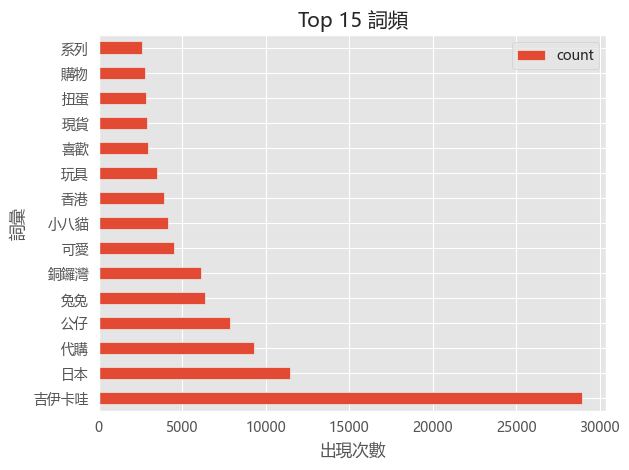

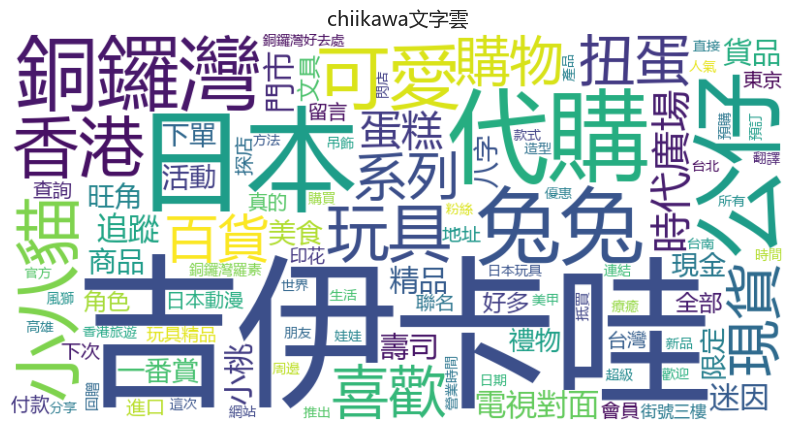

In [44]:
# Áπ™Ë£ΩË©ûÈ†ªÈï∑Ê¢ùÂúñ
plt.figure(figsize=(12, 8))
word_counts.head(15).plot.barh(x='word', y='count')
plt.title('Top 15 Ë©ûÈ†ª')
plt.xlabel('Âá∫ÁèæÊ¨°Êï∏')
plt.ylabel('Ë©ûÂΩô')
plt.tight_layout()
plt.show()

# Â∞áË©ûÈ†ªËΩâÊèõÁÇ∫Â≠óÂÖ∏Ê†ºÂºè
word_freq = dict(zip(word_counts['word'], word_counts['count']))

# ‰ΩøÁî®Á≥ªÁµ±‰∏äÂèØÁî®ÁöÑÂ≠óÈ´îÁîüÊàêÊñáÂ≠óÈõ≤
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    collocations=False,
    font_path=r'C:\Windows\Fonts\msyh.ttc'  # Áõ¥Êé•ÊåáÂÆöÁ≥ªÁµ±‰∏≠ÁöÑÂæÆËªüÈõÖÈªëÂ≠óÈ´î
)
wordcloud.generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('chiikawaÊñáÂ≠óÈõ≤')
plt.show()

7. ÊÉÖÁ∑íÂàÜÊûê

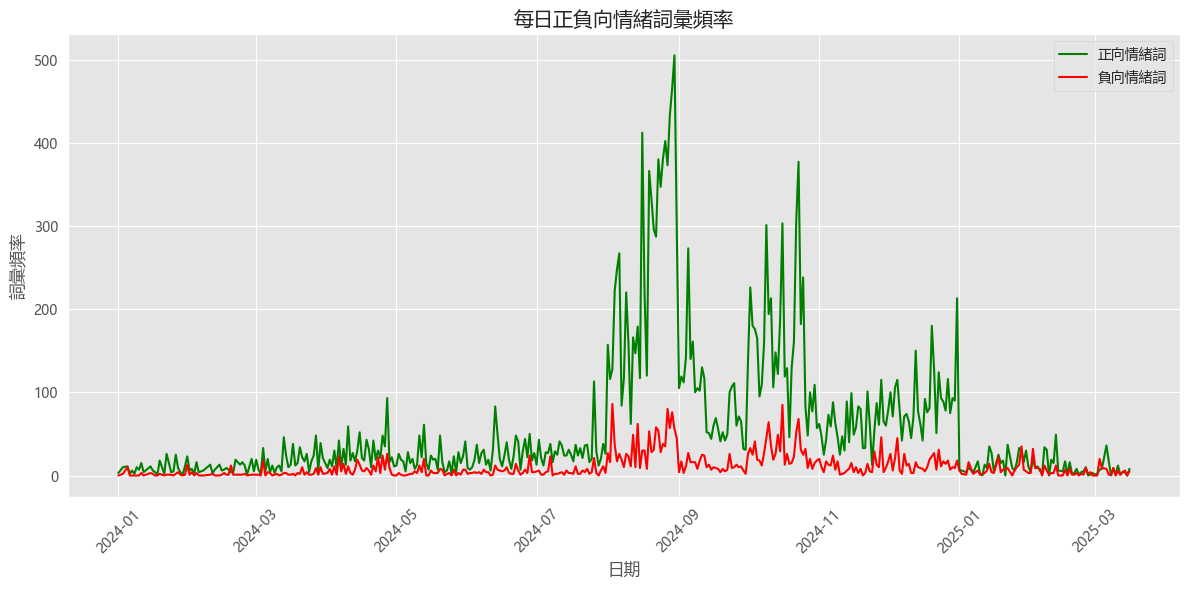

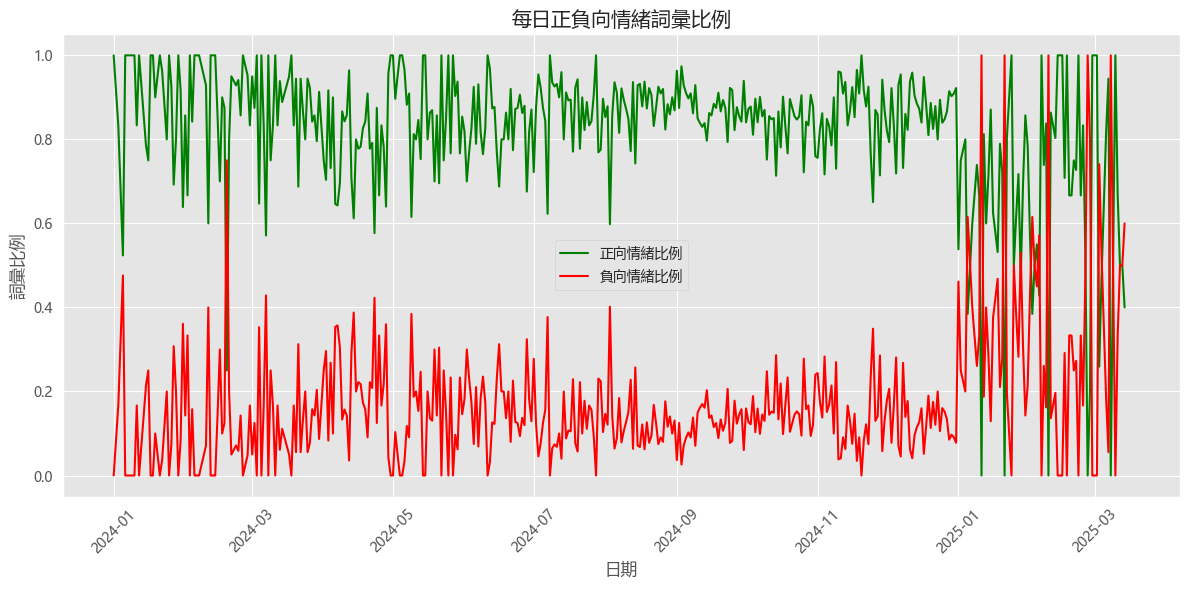

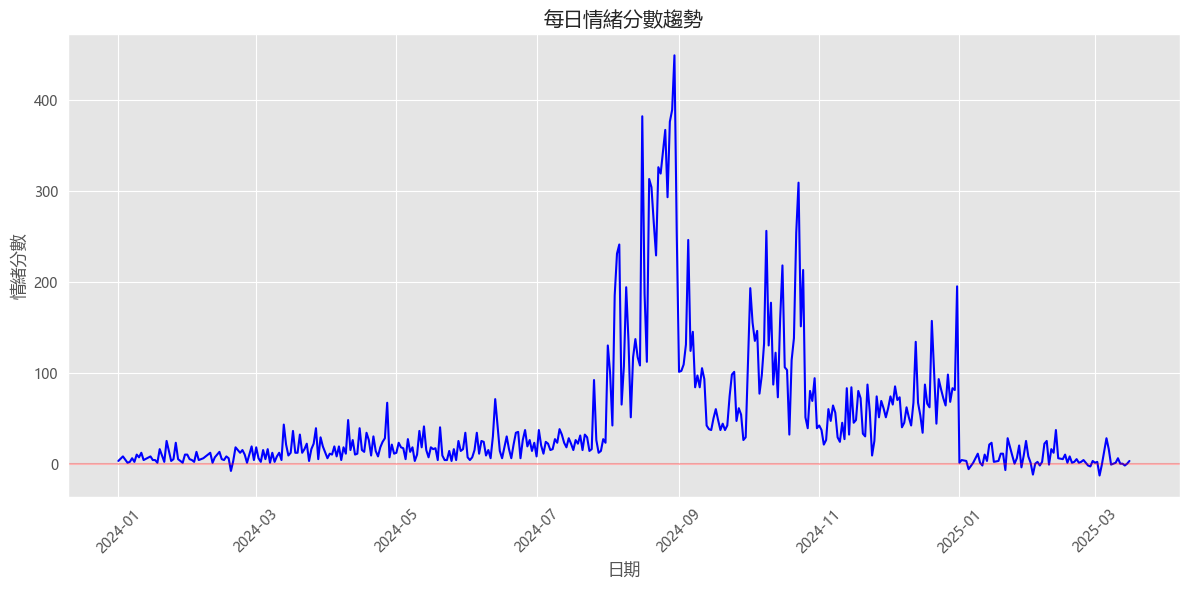

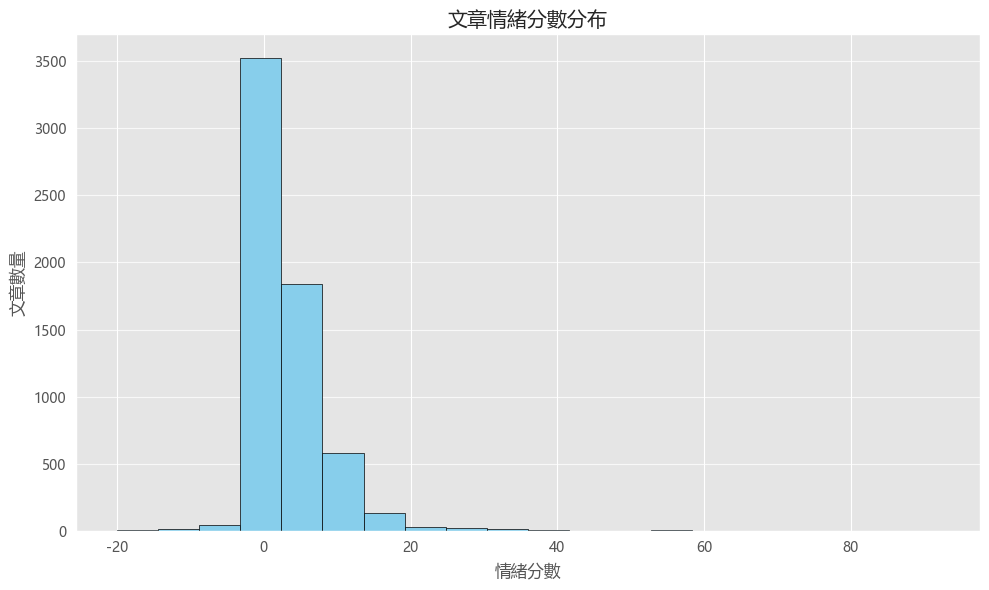

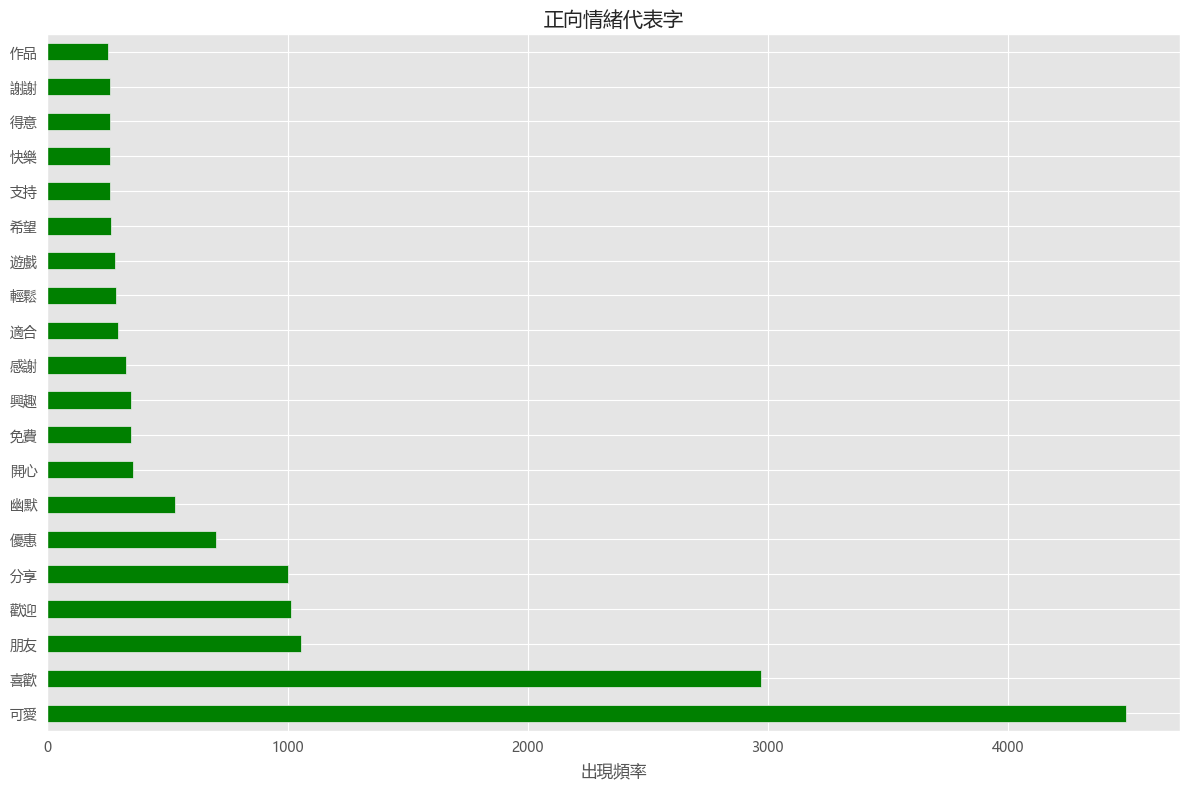

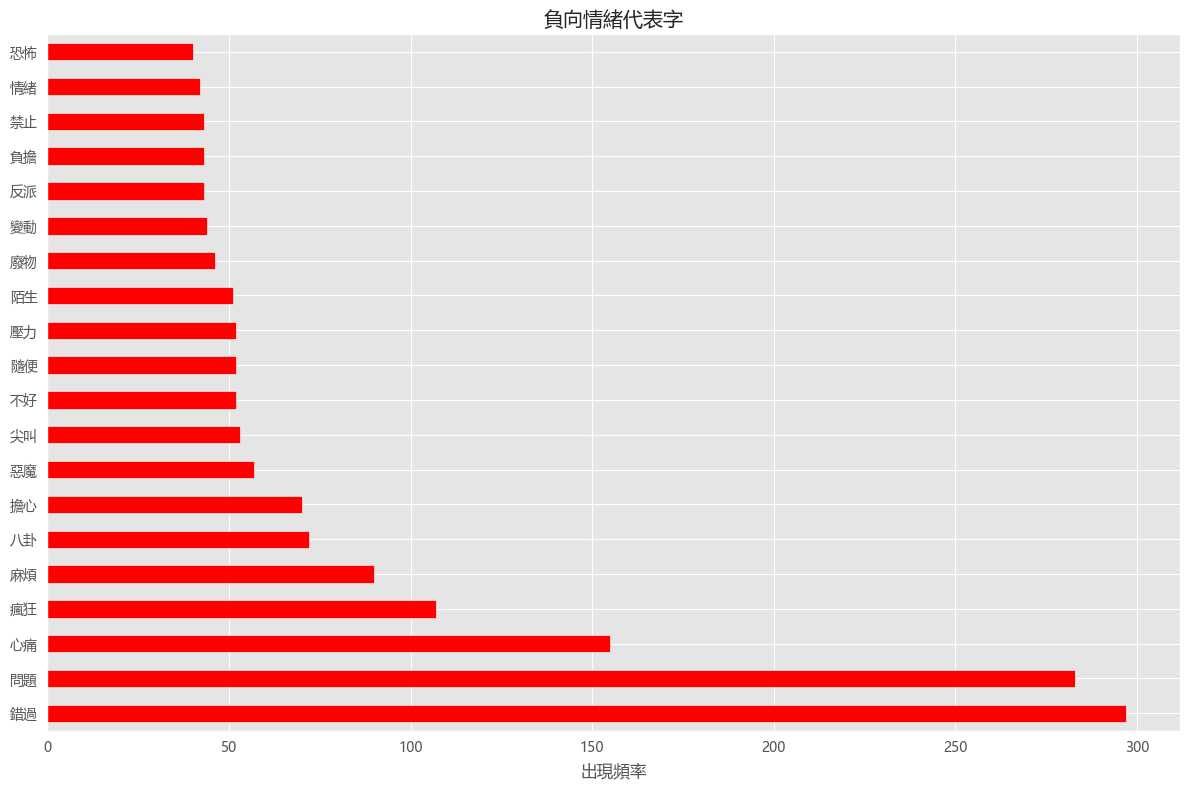

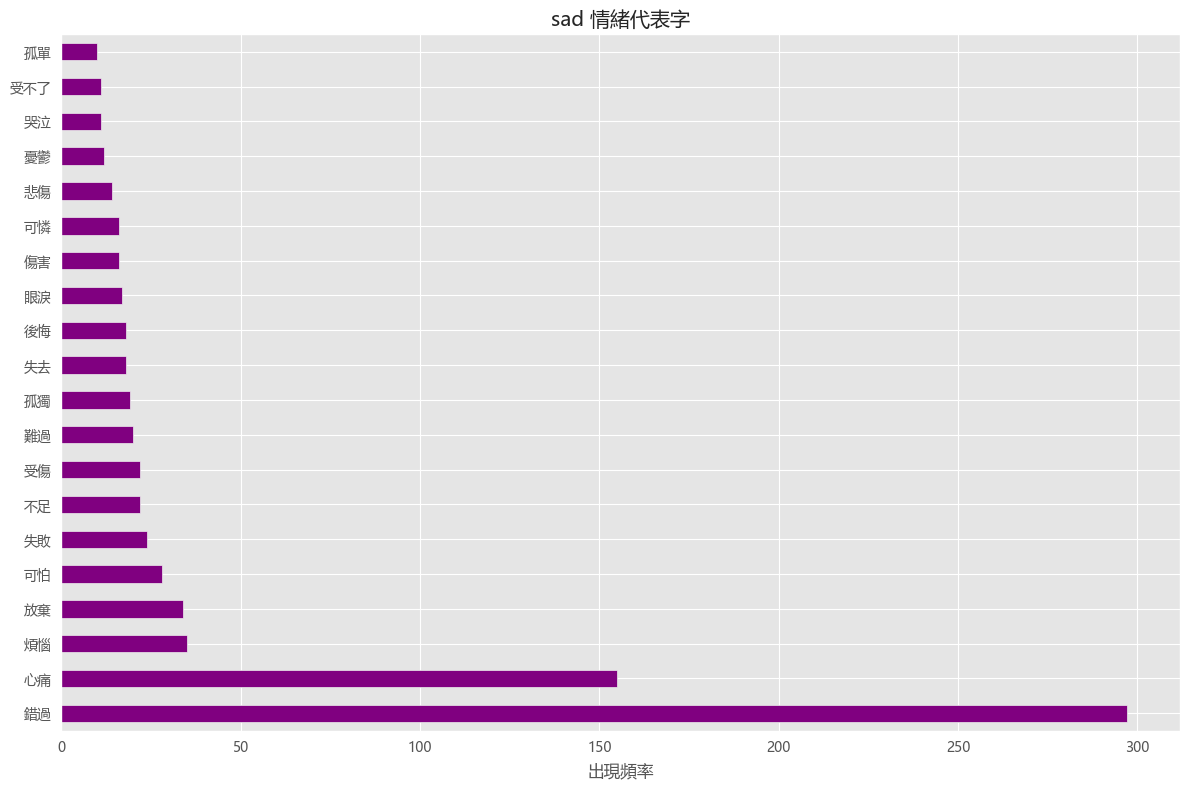

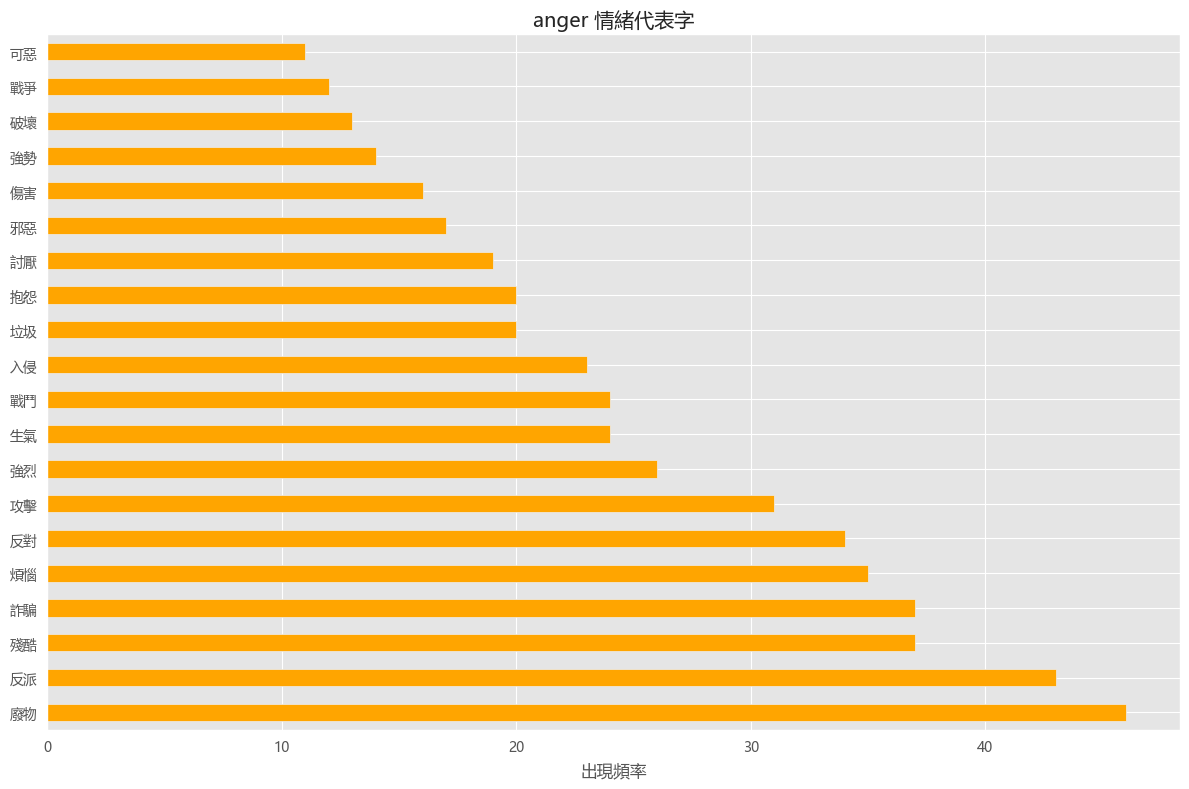

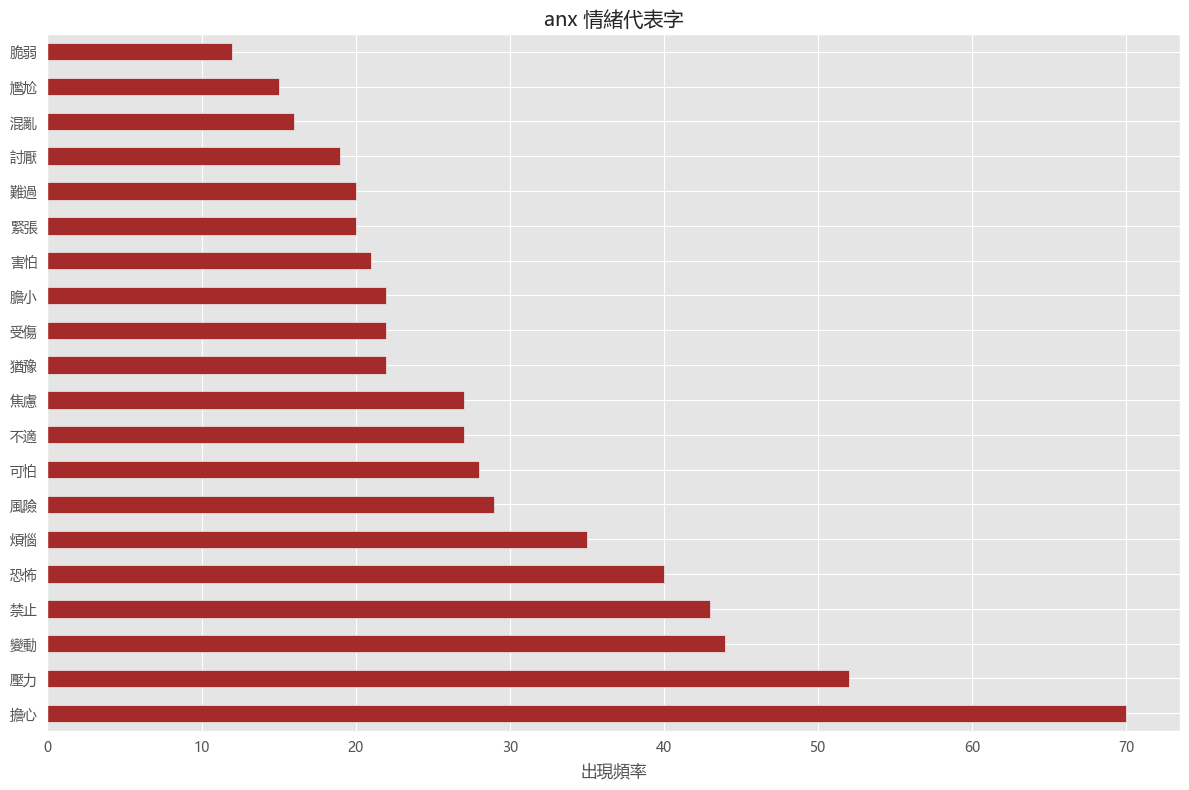

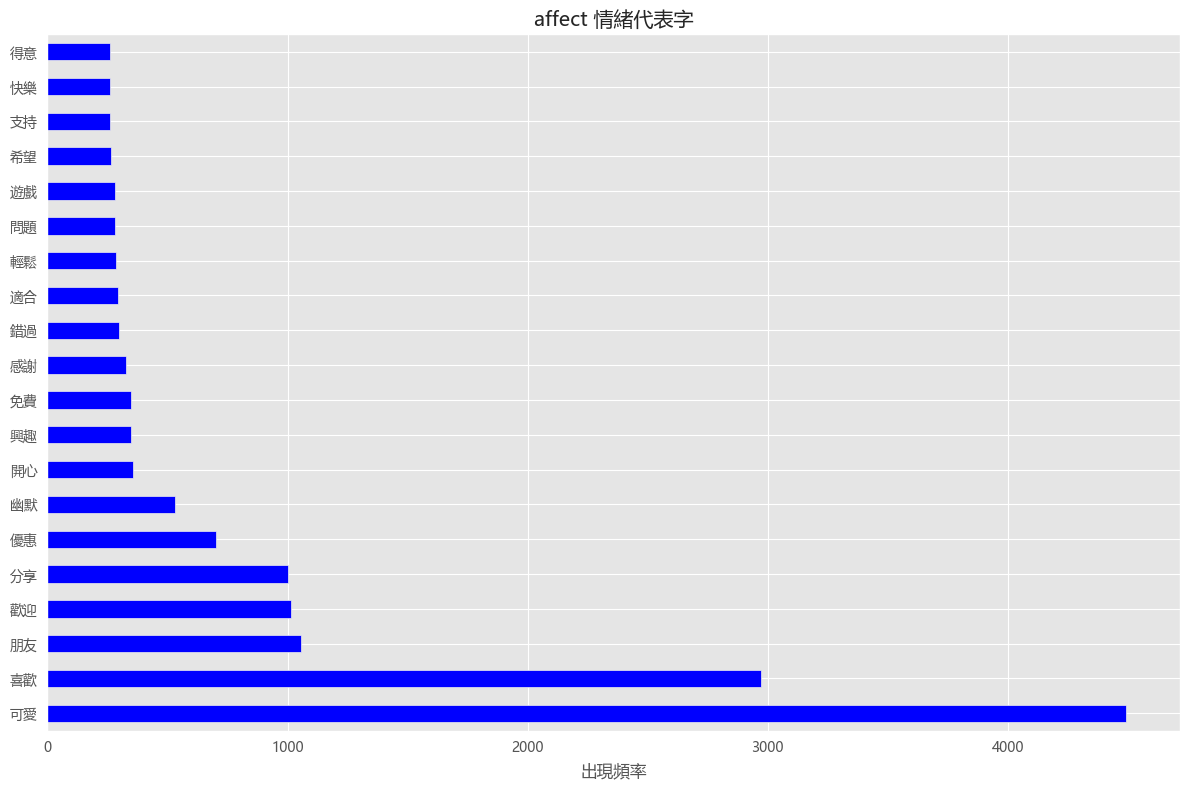

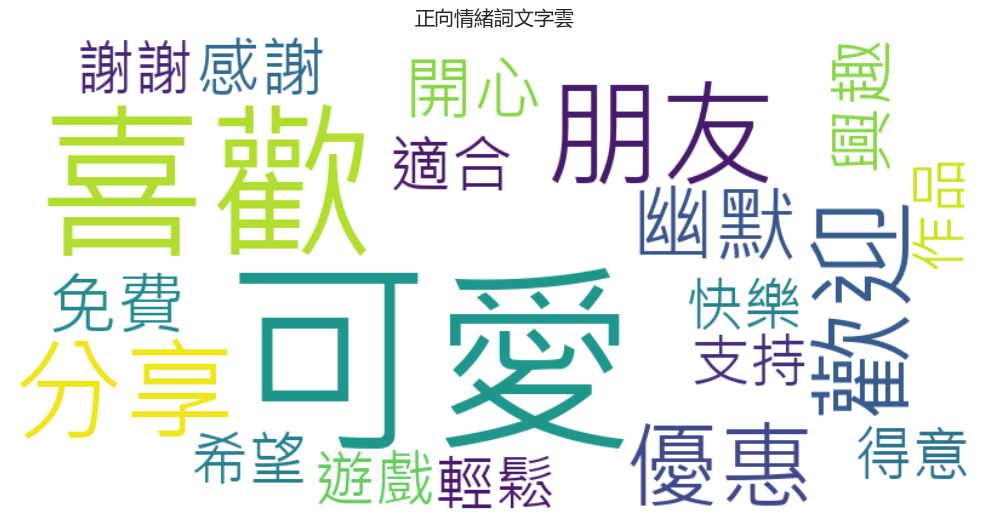

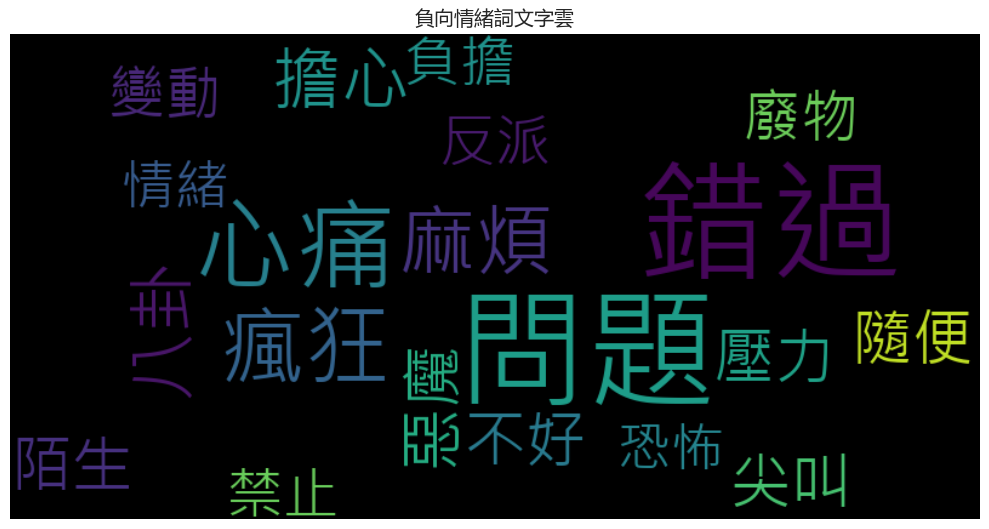

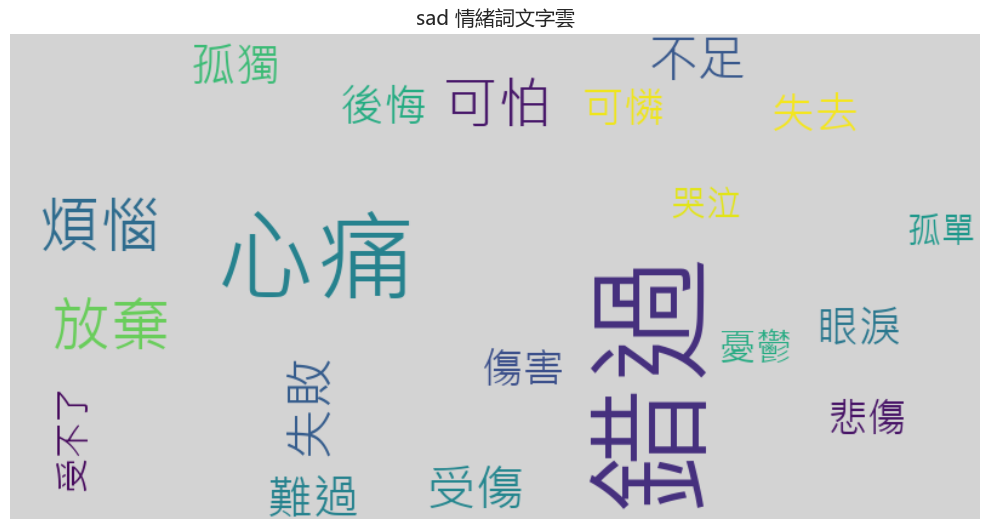

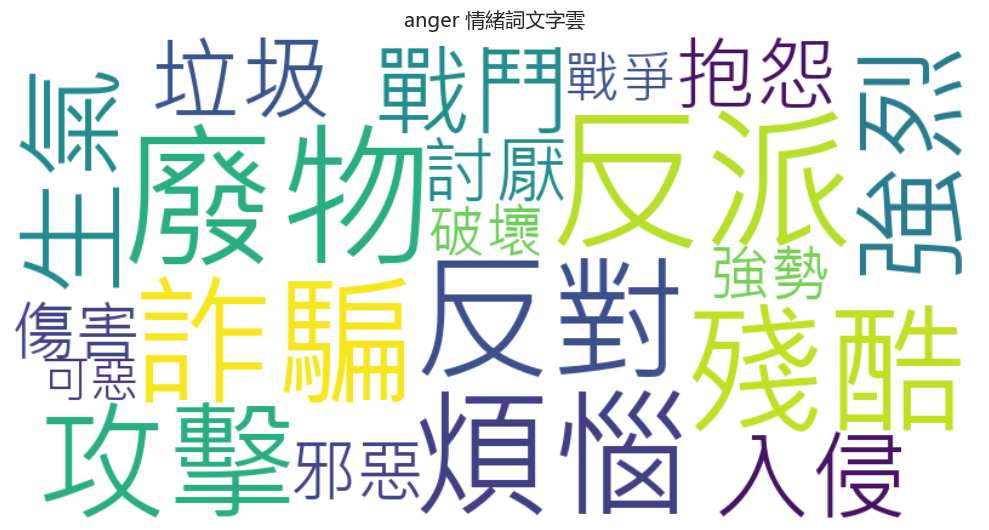

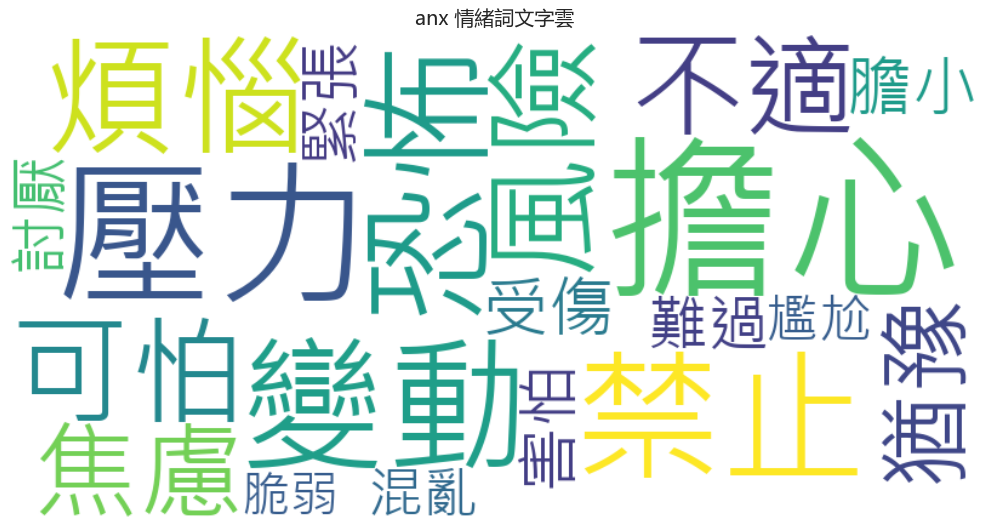

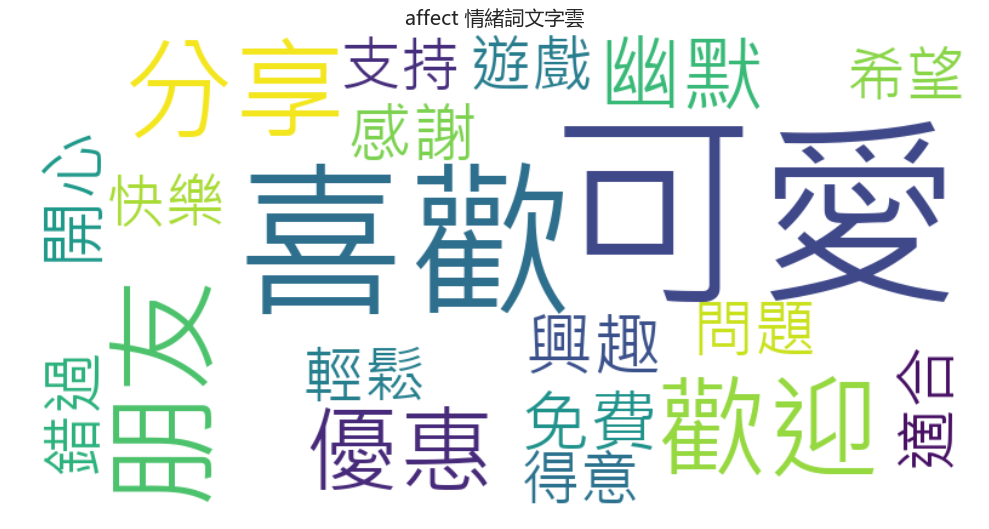

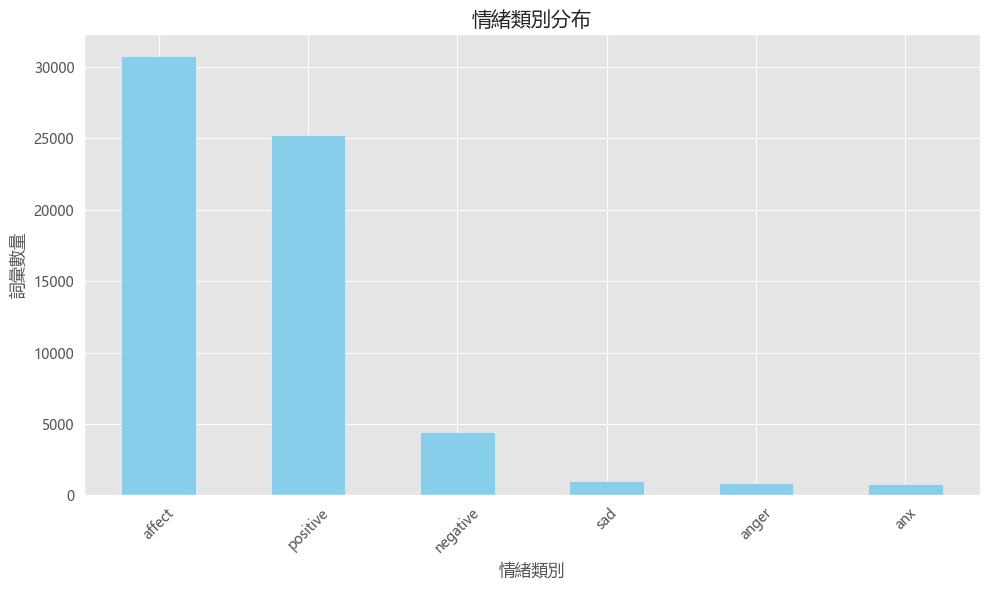

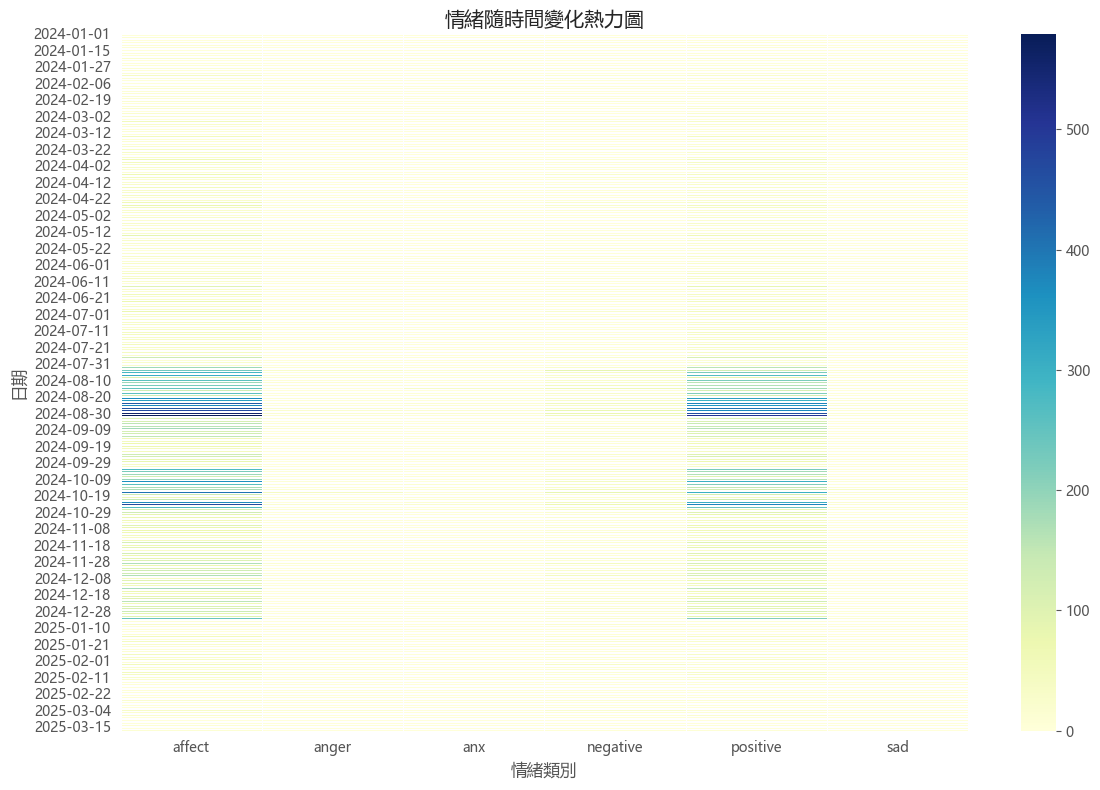

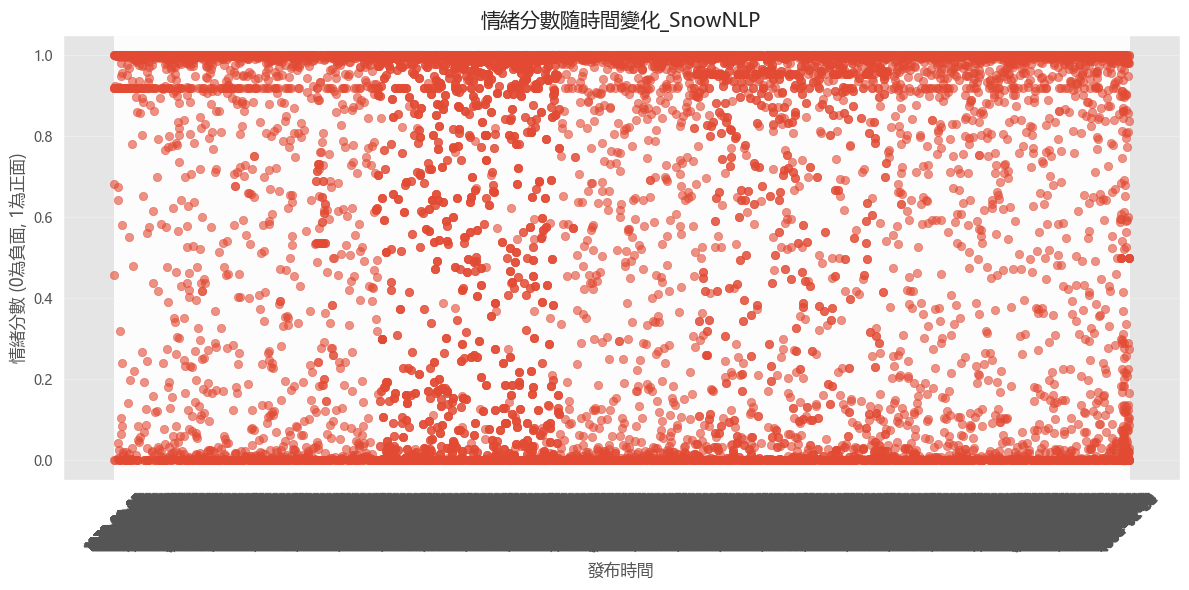

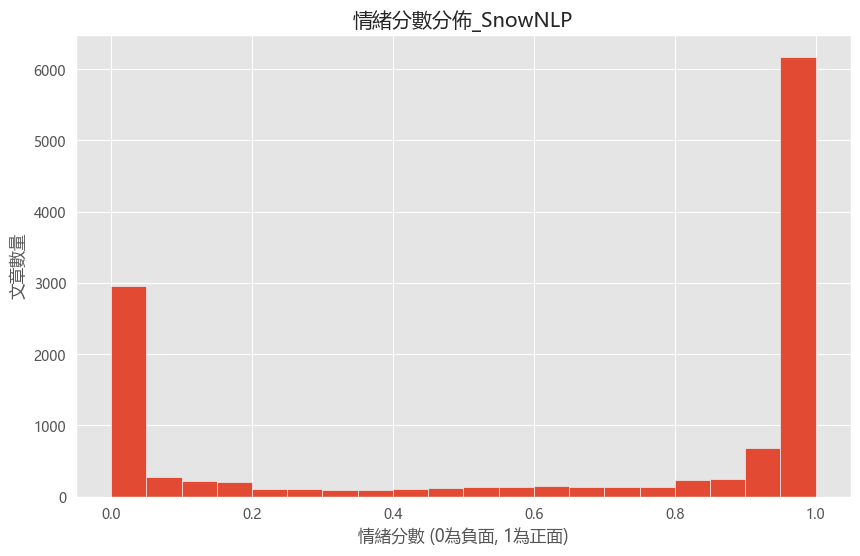

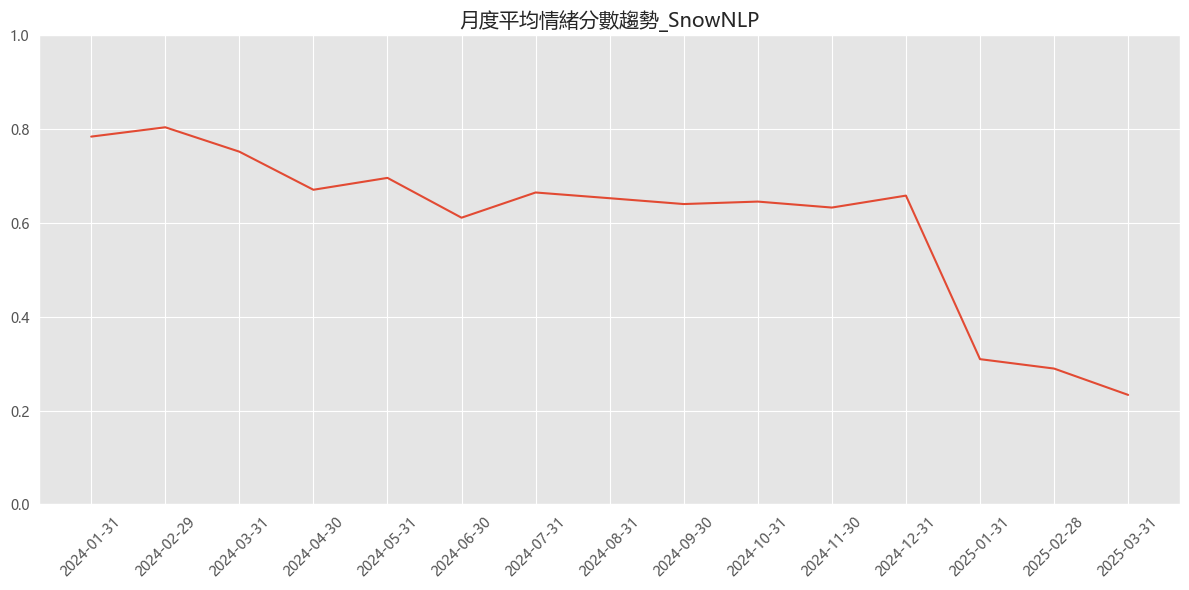

In [ ]:
# ËºâÂÖ•ÊÉÖÁ∑íË©ûÂÖ∏ 
liwc_dict = pd.read_csv("dict/liwc/LIWC_CH.csv")  
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

# Â∞áÂàÜË©ûÁµêÊûúÂ±ïÈñã‰ª•‰æøËàáÊÉÖÁ∑íÂ≠óÂÖ∏Âêà‰Ωµ
word_df = df.explode('flat_tokens')
word_df = word_df[word_df['flat_tokens'].notnull() & (word_df['flat_tokens'] != '')]
word_df = word_df.rename(columns={'flat_tokens': 'word'})

# Âêà‰ΩµÊÉÖÁ∑íË©ûÂÖ∏
liwc_df = pd.merge(word_df[["artUrl", "artDate", "artContent", "word"]], 
                   liwc_dict, how="left", on="word")

# Á¢∫‰øùÊó•ÊúüÊ†ºÂºèÊ≠£Á¢∫
liwc_df['date'] = pd.to_datetime(liwc_df['artDate']).dt.date

# Ë®àÁÆóÊØèÊó•ÊÉÖÁ∑íË©ûÈ†ªÁéá
daily_sentiment = liwc_df.groupby(['date', 'sentiments']).size().unstack(fill_value=0)

# Áπ™Ë£ΩÊØèÊó•ÊÉÖÁ∑íË©ûÈ†ªÁéá
plt.figure(figsize=(12, 6))
if 'positive' in daily_sentiment.columns:
    plt.plot(daily_sentiment.index, daily_sentiment['positive'], 'g-', label='Ê≠£ÂêëÊÉÖÁ∑íË©û')
if 'negative' in daily_sentiment.columns:
    plt.plot(daily_sentiment.index, daily_sentiment['negative'], 'r-', label='Ë≤†ÂêëÊÉÖÁ∑íË©û')

plt.title('ÊØèÊó•Ê≠£Ë≤†ÂêëÊÉÖÁ∑íË©ûÂΩôÈ†ªÁéá')
plt.xlabel('Êó•Êúü')
plt.ylabel('Ë©ûÂΩôÈ†ªÁéá')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Áπ™Ë£ΩÊ≠£Ë≤†ÂêëÊÉÖÁ∑íË©ûÊØî‰æã
if 'positive' in daily_sentiment.columns and 'negative' in daily_sentiment.columns:
    # Ë®àÁÆóÊ≠£Ë≤†ÂêëÊÉÖÁ∑íË©ûÊØî‰æãÔºåÈÅøÂÖçÈô§‰ª•Èõ∂
    total_emotions = daily_sentiment['positive'] + daily_sentiment['negative']
    daily_sentiment['pos_ratio'] = daily_sentiment['positive'] / total_emotions.replace(0, np.nan)
    daily_sentiment['neg_ratio'] = daily_sentiment['negative'] / total_emotions.replace(0, np.nan)

    plt.figure(figsize=(12, 6))
    plt.plot(daily_sentiment.index, daily_sentiment['pos_ratio'], 'g-', label='Ê≠£ÂêëÊÉÖÁ∑íÊØî‰æã')
    plt.plot(daily_sentiment.index, daily_sentiment['neg_ratio'], 'r-', label='Ë≤†ÂêëÊÉÖÁ∑íÊØî‰æã')
    plt.title('ÊØèÊó•Ê≠£Ë≤†ÂêëÊÉÖÁ∑íË©ûÂΩôÊØî‰æã')
    plt.xlabel('Êó•Êúü')
    plt.ylabel('Ë©ûÂΩôÊØî‰æã')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ë®àÁÆóÊØèÊó•ÊÉÖÁ∑íÂàÜÊï∏ (Ê≠£Âêë-Ë≤†Âêë)
if 'positive' in daily_sentiment.columns and 'negative' in daily_sentiment.columns:
    daily_sentiment['sentiment_score'] = daily_sentiment['positive'] - daily_sentiment['negative']

    plt.figure(figsize=(12, 6))
    plt.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], 'b-')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('ÊØèÊó•ÊÉÖÁ∑íÂàÜÊï∏Ë∂®Âã¢')
    plt.xlabel('Êó•Êúü')
    plt.ylabel('ÊÉÖÁ∑íÂàÜÊï∏')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ‰æùÊìöÊØèÁØáÊñáÁ´†ÁöÑÊÉÖÁ∑íË©ûÂàÜÊûê
article_sentiment = liwc_df.groupby(['artUrl', 'sentiments']).size().unstack(fill_value=0)

# Ë®àÁÆóÊØèÁØáÊñáÁ´†ÁöÑÊ≠£Ë≤†ÂêëÊÉÖÁ∑íÂàÜÊï∏
if 'positive' in article_sentiment.columns and 'negative' in article_sentiment.columns:
    article_sentiment['sentiment_score'] = article_sentiment['positive'] - article_sentiment['negative']

    # Êü•ÁúãÊñáÁ´†ÊÉÖÁ∑íÂàÜÊï∏ÂàÜÂ∏É
    plt.figure(figsize=(10, 6))
    plt.hist(article_sentiment['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
    plt.title('ÊñáÁ´†ÊÉÖÁ∑íÂàÜÊï∏ÂàÜÂ∏É')
    plt.xlabel('ÊÉÖÁ∑íÂàÜÊï∏')
    plt.ylabel('ÊñáÁ´†Êï∏Èáè')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

# Áµ±Ë®àÊÉÖÁ∑íË©ûÂΩô
def get_top_words(sentiment_type):
    # ÈÅéÊøæÂá∫ÈùûNaNÊÉÖÁ∑íÈ°ûÂà•ÁöÑË©ûÂΩô
    filtered_df = liwc_df[liwc_df['sentiments'] == sentiment_type]
    if filtered_df.empty:
        return pd.Series([])
    words = filtered_df['word'].value_counts().head(20)
    return words

# ‰ΩøÁî®Ê≠£Á¢∫ÁöÑÊÉÖÁ∑íÈ°ûÂà•ÂêçÁ®±
positive_words = get_top_words('positive')
negative_words = get_top_words('negative')

# Áπ™Ë£ΩÊ≠£ÂêëÊÉÖÁ∑í‰ª£Ë°®Â≠ó
if not positive_words.empty:
    plt.figure(figsize=(12, 8))
    positive_words.plot(kind='barh', color='green')
    plt.title('Ê≠£ÂêëÊÉÖÁ∑í‰ª£Ë°®Â≠ó')
    plt.xlabel('Âá∫ÁèæÈ†ªÁéá')
    plt.tight_layout()
    plt.show()

# Áπ™Ë£ΩË≤†ÂêëÊÉÖÁ∑í‰ª£Ë°®Â≠ó
if not negative_words.empty:
    plt.figure(figsize=(12, 8))
    negative_words.plot(kind='barh', color='red')
    plt.title('Ë≤†ÂêëÊÉÖÁ∑í‰ª£Ë°®Â≠ó')
    plt.xlabel('Âá∫ÁèæÈ†ªÁéá')
    plt.tight_layout()
    plt.show()

# Áπ™Ë£ΩÂÖ∂‰ªñÊÉÖÁ∑íÈ°ûÂà•ÁöÑ‰ª£Ë°®Â≠ó
other_sentiments = ['sad', 'anger', 'anx', 'affect']
colors = ['purple', 'orange', 'brown', 'blue']

for sentiment_type, color in zip(other_sentiments, colors):
    words = get_top_words(sentiment_type)
    if not words.empty:
        plt.figure(figsize=(12, 8))
        words.plot(kind='barh', color=color)
        plt.title(f'{sentiment_type} ÊÉÖÁ∑í‰ª£Ë°®Â≠ó')
        plt.xlabel('Âá∫ÁèæÈ†ªÁéá')
        plt.tight_layout()
        plt.show()

# Ë£Ω‰ΩúÊÉÖÁ∑íË©ûÁöÑÊñáÂ≠óÈõ≤
def generate_wordcloud(words_dict, title, color='white'):
    if not words_dict:
        print(f"Ê≤íÊúâË∂≥Â§†ÁöÑË©ûÂΩôÂª∫Á´ã {title}")
        return
        
    wordcloud = WordCloud(
        font_path='./font/msjh.ttc',  # ‰ΩøÁî®‰∏≠ÊñáÂ≠óÈ´î
        background_color=color,
        width=800,
        height=400,
        max_words=100
    ).generate_from_frequencies(words_dict)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Ê≠£ÂêëÊÉÖÁ∑íË©ûÊñáÂ≠óÈõ≤
if not positive_words.empty:
    positive_dict = dict(positive_words)
    generate_wordcloud(positive_dict, 'Ê≠£ÂêëÊÉÖÁ∑íË©ûÊñáÂ≠óÈõ≤', color='white')

# Ë≤†ÂêëÊÉÖÁ∑íË©ûÊñáÂ≠óÈõ≤
if not negative_words.empty:
    negative_dict = dict(negative_words)
    generate_wordcloud(negative_dict, 'Ë≤†ÂêëÊÉÖÁ∑íË©ûÊñáÂ≠óÈõ≤', color='black')

# ÂÖ∂‰ªñÊÉÖÁ∑íÈ°ûÂà•ÊñáÂ≠óÈõ≤
for sentiment_type in other_sentiments:
    words = get_top_words(sentiment_type)
    if not words.empty:
        words_dict = dict(words)
        bg_color = 'white' if sentiment_type != 'sad' else 'lightgray'
        generate_wordcloud(words_dict, f'{sentiment_type} ÊÉÖÁ∑íË©ûÊñáÂ≠óÈõ≤', color=bg_color)

# Áπ™Ë£ΩÊâÄÊúâÊÉÖÁ∑íÈ°ûÂà•ÁöÑÂàÜÂ∏ÉÊÉÖÊ≥Å
plt.figure(figsize=(10, 6))
sentiment_counts = liwc_df['sentiments'].value_counts()
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('ÊÉÖÁ∑íÈ°ûÂà•ÂàÜÂ∏É')
plt.xlabel('ÊÉÖÁ∑íÈ°ûÂà•')
plt.ylabel('Ë©ûÂΩôÊï∏Èáè')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Áπ™Ë£ΩÊÉÖÁ∑íÈö®ÊôÇÈñìËÆäÂåñÁöÑÁÜ±ÂäõÂúñ
sentiment_time = liwc_df.pivot_table(
    index='date', 
    columns='sentiments', 
    aggfunc='size', 
    fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_time, cmap='YlGnBu', linewidths=.5)
plt.title('ÊÉÖÁ∑íÈö®ÊôÇÈñìËÆäÂåñÁÜ±ÂäõÂúñ')
plt.ylabel('Êó•Êúü')
plt.xlabel('ÊÉÖÁ∑íÈ°ûÂà•')
plt.tight_layout()
plt.show()



8. SnowNLPÊÉÖÁ∑íÂàÜÊûê

In [ ]:
# ‰ΩøÁî®SnowNLPÈÄ≤Ë°åÁ¨¨‰∫åÈöéÊÆµÁöÑÊÉÖÁ∑íÂàÜÊûêÔºå‰∏¶Á¢∫Ë™ç lambda Áµ¶ SnowNLP ÁöÑÂ≠ó‰∏≤‰∏çÊúÉÁ©∫
df['sentiment_score'] = df['clean_content'].apply(
    lambda x: SnowNLP(x).sentiments if isinstance(x, str) and x.strip() else 0.5
)

# ÊåâÊôÇÈñìÊéíÂ∫è
df_sorted = df.sort_values('artDate')

# Êï£ÈªûÂúñÂ±ïÁ§∫ÊÉÖÁ∑íÈö®ÊôÇÈñìËÆäÂåñ
plt.figure(figsize=(12, 6))
plt.scatter(df_sorted['artDate'], df_sorted['sentiment_score'], alpha=0.6)
plt.title('ÊÉÖÁ∑íÂàÜÊï∏Èö®ÊôÇÈñìËÆäÂåñ_SnowNLP')
plt.xlabel('ÁôºÂ∏ÉÊôÇÈñì')
plt.ylabel('ÊÉÖÁ∑íÂàÜÊï∏ (0ÁÇ∫Ë≤†Èù¢, 1ÁÇ∫Ê≠£Èù¢)')
plt.grid(True, alpha=0.3)

# Áπ™Ë£ΩÊôÇÈñìËª∏
years_fmt = plt.matplotlib.dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Áπ™Ë£ΩÊÉÖÁ∑íÂàÜÊï∏ÂàÜ‰ΩàÂúñ
plt.figure(figsize=(10, 6))
plt.hist(df['sentiment_score'], bins=20)
plt.title('ÊÉÖÁ∑íÂàÜÊï∏ÂàÜ‰Ωà_SnowNLP') # Ê®ôÈ°åÂèØ‰ª•ÂçÄÂàÜ‰∏Ä‰∏ã
plt.xlabel('ÊÉÖÁ∑íÂàÜÊï∏ (0ÁÇ∫Ë≤†Èù¢, 1ÁÇ∫Ê≠£Èù¢)')
plt.ylabel('ÊñáÁ´†Êï∏Èáè')
plt.show()

# Â∞áÊó•ÊúüËΩâÊèõÁÇ∫ÊôÇÈñìÁ¥¢Âºï‰∏¶Ë®àÁÆóÊúàÂ∫¶Âπ≥ÂùáÊÉÖÁ∑íÂàÜÊï∏
df['artDate'] = pd.to_datetime(df['artDate']) # Á¢∫‰øùÊòØ Timestamp
monthly_sentiment = df.set_index('artDate').resample('M')['sentiment_score'].mean() 

# Áπ™Ë£ΩÊúàÂ∫¶ÊÉÖÁ∑íË∂®Âã¢Âúñ
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment.index.astype(str), monthly_sentiment.values)
plt.title('ÊúàÂ∫¶Âπ≥ÂùáÊÉÖÁ∑íÂàÜÊï∏Ë∂®Âã¢_SnowNLP')
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

9. TF-IDFÂàÜÊûêËàá‰∏ªÈ°åÂª∫Ê®°

Ââç20ÂÄãÊúÄÈáçË¶ÅË©ûÂΩô (Âü∫ÊñºÂπ≥ÂùáTF-IDF):
Êó•Êú¨       0.055930
‰ª£Ë≥º       0.052809
ÈäÖÈëºÁÅ£      0.049382
ÂÖ¨‰ªî       0.045378
ÂÖîÂÖî       0.044553
Â∞èÂÖ´Ë≤ì      0.035842
ÂèØÊÑõ       0.031493
ÂñúÊ≠°       0.027042
Ëø∑Âõ†       0.026059
È¶ôÊ∏Ø       0.025921
Áé©ÂÖ∑       0.025161
ÂèàÂ∞èÂèàÂèØÊÑõ    0.024369
Êâ≠Ëõã       0.022351
ËøΩËπ§       0.021777
Ë≥ºÁâ©       0.020968
Â£ΩÂè∏       0.020509
ÁôæË≤®       0.020356
ÊôÇ‰ª£Âª£Â†¥     0.019813
ÈõªË¶ñÂ∞çÈù¢     0.019712
Â∞èÊ°É       0.019204
dtype: float64


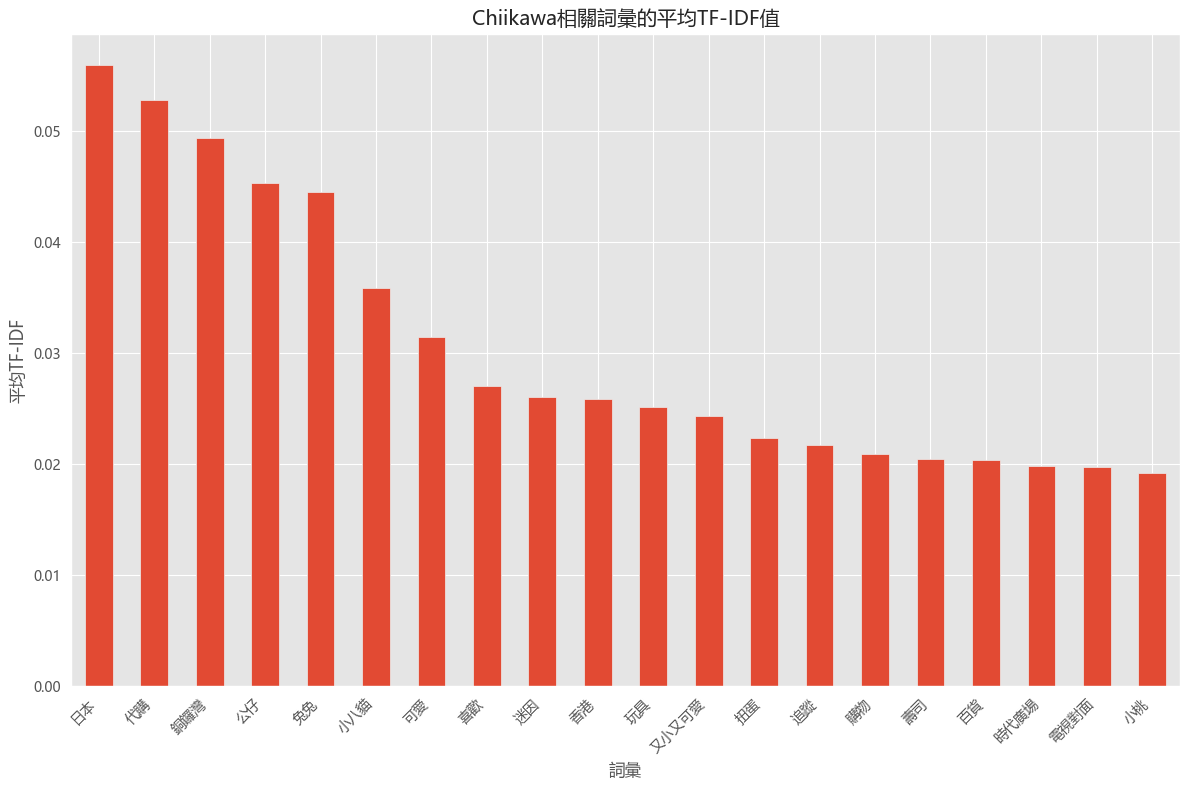


ÊñáÁ´† 1:
Ê®ôÈ°å: [ÈñíËÅä] ËΩâÁîüÂà∞Âêâ‰ºäÂç°ÂìáÁöÑ‰∏ñÁïåÊúâËæ¶Ê≥ïÁîüÂ≠òÂóé
‰æÜÊ∫ê: PTT
ÈáçË¶ÅË©ûÂΩô:
  - Ëæ¶Ê≥ï: 0.5229
  - Êúâ‰∫∫: 0.4698
  - ÁîüÁâ©: 0.4614
  - Áü•ÈÅì: 0.4083
  - ‰∏ñÁïå: 0.3554

ÊñáÁ´† 2:
Ê®ôÈ°å: ÁÑ°Ê®ôÈ°å(Instagram)
‰æÜÊ∫ê: IG
ÈáçË¶ÅË©ûÂΩô:
  - Â•Ω‰∫∫: 0.5029
  - ÈñãÁÆ±: 0.4997
  - ÁúãÂà∞: 0.4175
  - Âè∞Âåó: 0.4097
  - ÁîüÊ¥ª: 0.3941

ÊñáÁ´† 3:
Ê®ôÈ°å: „ÄêÈõúË´á„ÄëËóèÂ£ΩÂè∏Âêâ‰ºäÂç°ÂìáÊâ≠ËõãÊà∞ÊûúÂ†±ÂëäÔºÅÁ©∂Á´üÊ•ìÊ¢®Áï∂Â§©ÂêÉ‰∫ÜÂπæÁõ§ÔºüÊúÄÂæåÊúâÊäΩÂà∞ÂóéÔºüÔºü„Äê Á†ÇÁ≥ñÊ•ìÊ¢® Sato Furi „Äë
‰æÜÊ∫ê: YT
ÈáçË¶ÅË©ûÂΩô:
  - Áõ¥Êí≠: 0.4940
  - Â∞äÈáç: 0.2745
  - ËÄÅÂ∏´: 0.2577
  - Ë©±È°å: 0.2492
  - ÂÇ≥ÈÄÅÈñÄ: 0.2488

ÊñáÁ´† 4:
Ê®ôÈ°å: ÁÑ°Ê®ôÈ°å(Instagram)
‰æÜÊ∫ê: IG
ÈáçË¶ÅË©ûÂΩô:
  - ÈäÖÈëºÁÅ£: 0.5108
  - ÂÖîÂÖî: 0.2674
  - ÂÖ¨‰ªî: 0.2269
  - ÈõªË¶ñÂ∞çÈù¢: 0.2077
  - ÊôÇ‰ª£Âª£Â†¥: 0.2074

ÊñáÁ´† 5:
Ê®ôÈ°å: ÁÑ°Ê®ôÈ°å(Instagram)
‰æÜÊ∫ê: IG
ÈáçË¶ÅË©ûÂΩô:
  - ÈäÖÈëºÁÅ£: 0.4851
  - Â§öÊ¨æ: 0.2902
  - Êâ≠Ëõã: 0.2644
  - Êó•Êú¨: 0.2306
  - ÂÖ¨‰ªî: 0.2155


In [47]:
# È¶ñÂÖàÁ¢∫‰øùdataframe‰∏≠ÁöÑtokenÂàóÂ∑≤Ê∫ñÂÇôÂ•Ω
# Âêà‰ΩµÊñáÊ™î‰∏≠ÁöÑtokenÔºåËΩâÁÇ∫Â≠óÁ¨¶‰∏≤‰ª•‰æõsklearn‰ΩøÁî®
df['token_text'] = df['flat_tokens'].apply(
    lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else ''
)

# ÂâµÂª∫TF-IDFÂêëÈáèÂåñÂô®
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # ÊúÄÂ§ö‰øùÁïô1000ÂÄãÁâπÂæµË©û
    min_df=5,           # Ëá≥Â∞ëÂá∫ÁèæÂú®5ÂÄãÊñáÊ™î‰∏≠
    max_df=0.8,         # ÊúÄÂ§öÂá∫ÁèæÂú®80%ÁöÑÊñáÊ™î‰∏≠
)

# ËΩâÊèõÊñáÊ™î
tfidf_matrix = tfidf_vectorizer.fit_transform(df['token_text'].fillna(''))

# Áç≤ÂèñÁâπÂæµË©ûÂàóË°®
feature_names = tfidf_vectorizer.get_feature_names_out()

# Â∞áTF-IDFÁü©Èô£ËΩâÊèõÁÇ∫DataFrame‰ª•Êñπ‰æøÊü•Áúã
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Ë®àÁÆóÊØèÂÄãË©ûÁöÑÂπ≥ÂùáTF-IDFÂÄº
avg_tfidf = tfidf_df.mean().sort_values(ascending=False)

# È°ØÁ§∫Ââç20ÂÄãÊúÄÈáçË¶ÅÁöÑË©û
print("Ââç20ÂÄãÊúÄÈáçË¶ÅË©ûÂΩô (Âü∫ÊñºÂπ≥ÂùáTF-IDF):")
print(avg_tfidf.head(20))

# ÂèØË¶ñÂåñÂâç20ÂÄãË©ûÁöÑTF-IDFÂÄº
plt.figure(figsize=(12, 8))
avg_tfidf.head(20).plot(kind='bar')
plt.title('ChiikawaÁõ∏ÈóúË©ûÂΩôÁöÑÂπ≥ÂùáTF-IDFÂÄº')
plt.xlabel('Ë©ûÂΩô')
plt.ylabel('Âπ≥ÂùáTF-IDF')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ÊâæÂá∫ÊØèÁØáÊñáÁ´†‰∏≠ÊúÄÈáçË¶ÅÁöÑË©ûÂΩô
top_words_per_doc = []
for i, row in enumerate(tfidf_matrix.toarray()):
    # Áç≤ÂèñTF-IDFÂÄºÊúÄÈ´òÁöÑ5ÂÄãË©ûÁöÑÁ¥¢Âºï
    top_indices = row.argsort()[-5:][::-1]
    # Áç≤ÂèñÈÄô‰∫õË©û
    top_words = [(feature_names[idx], row[idx]) for idx in top_indices]
    top_words_per_doc.append(top_words)

# Â∞áÊúÄÈáçË¶ÅÁöÑË©ûÂä†ÂÖ•Âà∞ÂéüÂßãDataFrame
df['top_tfidf_words'] = top_words_per_doc

# Èö®Ê©üÈ°ØÁ§∫5ÁØáÊñáÁ´†ÁöÑÊ®ôÈ°åÂèäÂÖ∂ÈáçË¶ÅË©ûÂΩô
sample_docs = df.sample(5)
for i, (idx, doc) in enumerate(sample_docs.iterrows()):
    print(f"\nÊñáÁ´† {i+1}:")
    print(f"Ê®ôÈ°å: {doc['artTitle'] if doc['artTitle'] else 'ÁÑ°Ê®ôÈ°å(Instagram)'}")
    print(f"‰æÜÊ∫ê: {doc['dataSource']}")
    print("ÈáçË¶ÅË©ûÂΩô:")
    for word, score in doc['top_tfidf_words']:
        print(f"  - {word}: {score:.4f}")

10.ÊñáÊ™îÁõ∏‰ººÂ∫¶ÂàÜÊûêËàáËÅöÈ°û

ËàáÊñáÁ´† 1 ÊúÄÁõ∏‰ººÁöÑÊñáÁ´†:
ÊñáÁ´† 9: Áõ∏‰ººÂ∫¶ 1.0000
Ê®ôÈ°å: „ÄêChiikawa„ÄëÁù°Ë°£Ê¥æÂ∞ç‰πãÊ≠å / „Éë„Ç∏„É£„Éû„Éë„Éº„ÉÜ„Ç£„Éº„Ç∫„ÅÆ„ÅÜ„Åü Âª£Êù±Ë©±Ê≠åË©û...
--------------------------------------------------
ÊñáÁ´† 6926: Áõ∏‰ººÂ∫¶ 0.8177
Ê®ôÈ°å: ...
--------------------------------------------------
ÊñáÁ´† 21: Áõ∏‰ººÂ∫¶ 0.8177
Ê®ôÈ°å: ÊâìÈñã Illustrator ÂóöÂìáÂìáÂóöÊåñÂ∞±ÂÅöÂ•Ω‰∫ÜÂêâ‰ºäÂç°ÂìáËªüÁ≥ñüêª‚Äç‚ùÑÔ∏è...
--------------------------------------------------
ÊñáÁ´† 3177: Áõ∏‰ººÂ∫¶ 0.8177
Ê®ôÈ°å: ...
--------------------------------------------------
ÊñáÁ´† 11404: Áõ∏‰ººÂ∫¶ 0.7069
Ê®ôÈ°å: ...
--------------------------------------------------
ÂêÑËÅöÈ°ûÊñáÁ´†Êï∏Èáè:
0    1163
1     931
2     510
3    9623
4     252
Name: cluster, dtype: int64


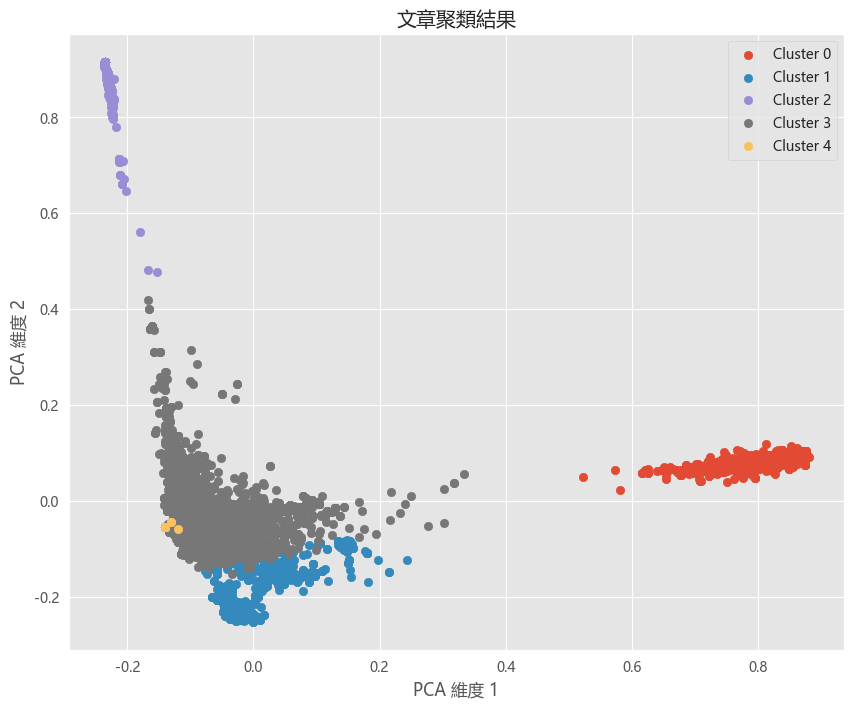

ÂêÑËÅöÈ°ûÈóúÈçµË©û:
  Cluster 0 Cluster 1 Cluster 2 Cluster 3 Cluster 4
0       ÈäÖÈëºÁÅ£        ‰ª£Ë≥º        Ëø∑Âõ†        Êó•Êú¨     ÂèàÂ∞èÂèàÂèØÊÑõ
1      ÊôÇ‰ª£Âª£Â†¥        Êó∫Ëßí        ËøΩËπ§        ÂÖîÂÖî        ËèØÂ±±
2      ÈõªË¶ñÂ∞çÈù¢        ÂÖ´Â≠ó        ÂñúÊ≠°       Â∞èÂÖ´Ë≤ì        ÈñÉÂ∫ó
3        ÁôæË≤®        Êó•Êú¨        ÁøªË≠Ø        ÂèØÊÑõ        ÂÇ¢‰ºô
4        ÂÖ¨‰ªî        ÂÖ¨‰ªî        ÂπΩÈªò        Â£ΩÂè∏        Á∂≤‰∏ä


In [56]:
# Ë®àÁÆóÊâÄÊúâÊñáÊ™î‰πãÈñìÁöÑÈ§òÂº¶Áõ∏‰ººÂ∫¶
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# ÂâµÂª∫Áõ∏‰ººÂ∫¶DataFrameÊñπ‰æøÊü•Áúã
similarity_df = pd.DataFrame(cosine_sim, 
                            index=df.index, 
                            columns=df.index)

# ‰æãÂ¶ÇÔºåÊü•ÁúãÁ¨¨1ÁØáÊñáÁ´†ËàáÂÖ∂‰ªñÊâÄÊúâÊñáÁ´†ÁöÑÁõ∏‰ººÂ∫¶
article_id = 1  # ÂÅáË®≠ÊàëÂÄëË¶ÅÊ™¢Êü•ÁöÑÊñáÁ´†ID
similar_articles = similarity_df[article_id].sort_values(ascending=False)

# ÊâìÂç∞Ââç5ÂÄãÊúÄÁõ∏‰ººÁöÑÊñáÁ´†(‰∏çÂåÖÊã¨Ëá™Â∑±)
print("ËàáÊñáÁ´† {} ÊúÄÁõ∏‰ººÁöÑÊñáÁ´†:".format(article_id))
for idx, score in similar_articles[1:6].items():
    print(f"ÊñáÁ´† {idx}: Áõ∏‰ººÂ∫¶ {score:.4f}")
    
    # ËôïÁêÜÊ®ôÈ°åÂèØËÉΩÊòØÈùûÂ≠óÁ¨¶‰∏≤ÁöÑÊÉÖÊ≥Å
    title = df.loc[idx, 'artTitle']
    if isinstance(title, str):
        print(f"Ê®ôÈ°å: {title[:50]}...")  # ÊâìÂç∞ÈÉ®ÂàÜÊ®ôÈ°å
    else:
        print(f"Ê®ôÈ°å: {str(title)}")
    
    print("-" * 50)

# ÈÅ∏ÊìáÂêàÈÅ©ÁöÑËÅöÈ°ûÊï∏ÈáèÔºåÈÄôË£°ÂÅáË®≠ÁÇ∫5
num_clusters = 5

# ‰ΩøÁî®K-meansËÅöÈ°û
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)

# Áç≤ÂèñËÅöÈ°ûÊ®ôÁ±§
clusters = km.labels_

# Â∞áËÅöÈ°ûÁµêÊûúÊ∑ªÂä†Âà∞ÂéüÂßãÊï∏ÊìöÊ°Ü
df['cluster'] = clusters

# Êü•ÁúãÊØèÂÄãËÅöÈ°ûÁöÑÊñáÁ´†Êï∏Èáè
cluster_counts = df['cluster'].value_counts().sort_index()
print("ÂêÑËÅöÈ°ûÊñáÁ´†Êï∏Èáè:")
print(cluster_counts)

# ÂèØË¶ñÂåñËÅöÈ°ûÁµêÊûú (‰ΩøÁî®PCAÈôçÁ∂≠Âà∞2DÁ©∫Èñì)
from sklearn.decomposition import PCA

# ÈôçÁ∂≠Âà∞2D
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# Áπ™Ë£ΩÊï£ÈªûÂúñ
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    # Áç≤ÂèñÂ±¨ÊñºÁ¨¨iÂÄãËÅöÈ°ûÁöÑÈªû
    points = reduced_features[clusters == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')

plt.title('ÊñáÁ´†ËÅöÈ°ûÁµêÊûú')
plt.xlabel('PCA Á∂≠Â∫¶ 1')
plt.ylabel('PCA Á∂≠Â∫¶ 2')
plt.legend()
plt.show()

# ÂàÜÊûêÊØèÂÄãËÅöÈ°ûÁöÑÈóúÈçµË©û
def get_top_keywords(tfidf_vectorizer, tfidf_matrix, clusters, n_terms=5):
    df_keywords = pd.DataFrame()
    # Áç≤ÂèñÁâπÂæµÂêçÁ®±(Ë©ûÂΩô)
    terms = tfidf_vectorizer.get_feature_names_out()
    
    for i in range(num_clusters):
        # Áç≤ÂèñÁ¨¨iÂÄãËÅöÈ°ûÁöÑÊâÄÊúâÊñáÊ™î
        docs_in_cluster = tfidf_matrix[clusters == i].toarray()
        # Ë®àÁÆóË©≤ËÅöÈ°û‰∏≠ÊØèÂÄãË©ûÁöÑÂπ≥ÂùáTF-IDFÂÄº
        centroid = docs_in_cluster.mean(axis=0)
        # Áç≤ÂèñÊéíÂêçÂâçnÁöÑË©ûÁöÑÁ¥¢Âºï
        top_indices = centroid.argsort()[-n_terms:][::-1]
        # Áç≤ÂèñÈÄô‰∫õË©û
        top_terms = [terms[j] for j in top_indices]
        
        df_keywords[f'Cluster {i}'] = top_terms
        
    return df_keywords

# Áç≤Âèñ‰∏¶È°ØÁ§∫ÊØèÂÄãËÅöÈ°ûÁöÑÈóúÈçµË©û
top_keywords = get_top_keywords(tfidf_vectorizer, tfidf_matrix, clusters)
print("ÂêÑËÅöÈ°ûÈóúÈçµË©û:")
print(top_keywords)

11. N-gramË™ûË®ÄÊ®°Âûã(Ë®òÊÜ∂È´î‰∏çË∂≥Ë∑ë‰∏çÂ§™Âãï)

In [52]:
# Á¢∫‰øùtokenÂàóÂ∑≤Ê∫ñÂÇôÂ•ΩÔºåÁÑ∂ÂæåÊßãÂª∫Êõ¥ÂÆåÂñÑÁöÑË™ûÊñôÂ∫´
tokenized_docs = df['flat_tokens'].tolist()
tokenized_docs = [doc for doc in tokenized_docs if isinstance(doc, list) and doc]

# ÊßãÂª∫BigramÂíåTrigramÈ†ªÁéáË°®
bigram_counts = defaultdict(Counter)
trigram_counts = defaultdict(Counter)

# Áµ±Ë®àBigramÂíåTrigramÈ†ªÁéá
for doc in tokenized_docs:
    for i in range(len(doc) - 1):
        # Bigram: Ë®òÈåÑÁ¨¨‰∏ÄÂÄãË©ûÂæåÈù¢Êé•Á¨¨‰∫åÂÄãË©ûÁöÑÈ†ªÁéá
        first_word = doc[i]
        next_word = doc[i + 1]
        bigram_counts[first_word][next_word] += 1
        
        # Trigram: Ë®òÈåÑÂâçÂÖ©ÂÄãË©ûÂæåÈù¢Êé•Á¨¨‰∏âÂÄãË©ûÁöÑÈ†ªÁéá
        if i < len(doc) - 2:
            first_two_words = (doc[i], doc[i + 1])
            next_word = doc[i + 2]
            trigram_counts[first_two_words][next_word] += 1

# ËΩâÊèõÁÇ∫Ê¢ù‰ª∂Ê¶ÇÁéá
bigram_probs = defaultdict(dict)
trigram_probs = defaultdict(dict)

# Ë®àÁÆóBigramÊ¢ù‰ª∂Ê¶ÇÁéá P(w2|w1)
for first_word, counter in bigram_counts.items():
    total_count = sum(counter.values())
    for next_word, count in counter.items():
        bigram_probs[first_word][next_word] = count / total_count

# Ë®àÁÆóTrigramÊ¢ù‰ª∂Ê¶ÇÁéá P(w3|w1,w2)
for first_two_words, counter in trigram_counts.items():
    total_count = sum(counter.values())
    for next_word, count in counter.items():
        trigram_probs[first_two_words][next_word] = count / total_count

# È†êÊ∏¨ÂáΩÊï∏ÔºöÁµ¶ÂÆöÂâç‰∏ÄÂÄãÊàñÂâçÂÖ©ÂÄãË©ûÔºåÈ†êÊ∏¨‰∏ã‰∏ÄÂÄãË©û
def predict_next_word(prev_words, model='bigram'):
    if model == 'bigram' and len(prev_words) >= 1:
        prev_word = prev_words[-1]
        if prev_word in bigram_probs:
            # ÊåâÊ¶ÇÁéáÈôçÂ∫èÊéíÂ∫è
            sorted_words = sorted(bigram_probs[prev_word].items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)
            return sorted_words[:5]  # ËøîÂõûÂâç5ÂÄãÊúÄÂèØËÉΩÁöÑË©û
    
    elif model == 'trigram' and len(prev_words) >= 2:
        prev_two_words = (prev_words[-2], prev_words[-1])
        if prev_two_words in trigram_probs:
            sorted_words = sorted(trigram_probs[prev_two_words].items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)
            return sorted_words[:5]
    
    return []  # Â¶ÇÊûúÊ≤íÊúâÂåπÈÖçÁöÑÊ®°ÂºèÊàñÂâç‰∏ÄÂÄãË©û‰∏çÂú®Ê®°Âûã‰∏≠ÔºåËøîÂõûÁ©∫ÂàóË°®

# Ê∏¨Ë©¶È†êÊ∏¨
test_words = ['Âêâ‰ºäÂç°Âìá']
bigram_predictions = predict_next_word(test_words, 'bigram')
print(f"‰ΩøÁî®BigramÊ®°ÂûãÔºå'{test_words[-1]}'ÂæåÈù¢ÊúÄÂèØËÉΩÁöÑË©û:")
for word, prob in bigram_predictions:
    print(f"{word}: {prob:.4f}")

# ÁîüÊàêÊñáÊú¨ÂáΩÊï∏
def generate_text(seed_words, model='bigram', length=20):
    if not seed_words:
        # Èö®Ê©üÈÅ∏Êìá‰∏ÄÂÄãË©û‰ΩúÁÇ∫Ëµ∑Âßã
        all_words = list(bigram_probs.keys())
        text = [random.choice(all_words)]
    else:
        text = list(seed_words)
    
    for _ in range(length):
        if model == 'bigram':
            prev_word = text[-1]
            if prev_word in bigram_probs and bigram_probs[prev_word]:
                # ÊåâÊ¶ÇÁéáÊäΩÊ®£
                words, probs = zip(*bigram_probs[prev_word].items())
                probs = np.array(probs) / sum(probs)  # Á¢∫‰øùÊ¶ÇÁéáÁ∏ΩÂíåÁÇ∫1
                next_word = np.random.choice(words, p=probs)
                text.append(next_word)
            else:
                # Â¶ÇÊûúÂâç‰∏ÄÂÄãË©û‰∏çÂú®Ê®°Âûã‰∏≠ÔºåÈö®Ê©üÈÅ∏Êìá‰∏ÄÂÄãË©û
                all_words = list(bigram_probs.keys())
                text.append(random.choice(all_words))
        
        elif model == 'trigram' and len(text) >= 2:
            prev_two_words = (text[-2], text[-1])
            if prev_two_words in trigram_probs and trigram_probs[prev_two_words]:
                words, probs = zip(*trigram_probs[prev_two_words].items())
                probs = np.array(probs) / sum(probs)
                next_word = np.random.choice(words, p=probs)
                text.append(next_word)
            else:
                # ÂõûÈÄÄÂà∞bigramÊ®°Âûã
                prev_word = text[-1]
                if prev_word in bigram_probs and bigram_probs[prev_word]:
                    words, probs = zip(*bigram_probs[prev_word].items())
                    probs = np.array(probs) / sum(probs)
                    next_word = np.random.choice(words, p=probs)
                    text.append(next_word)
                else:
                    all_words = list(bigram_probs.keys())
                    text.append(random.choice(all_words))
    
    return text

# Ê∏¨Ë©¶ÁîüÊàêÊñáÊú¨
seed_words = ['Âêâ‰ºäÂç°Âìá']
generated_text = generate_text(seed_words, model='bigram', length=15)
print(f"‰ΩøÁî®BigramÊ®°ÂûãÁîüÊàêÁöÑÊñáÊú¨ (Á®ÆÂ≠êË©û: {' '.join(seed_words)}):")
print(' '.join(generated_text))

# Ë©ï‰º∞ÂáΩÊï∏ÔºöË®àÁÆóÊ®°ÂûãÂú®Ê∏¨Ë©¶ÊñáÊú¨‰∏äÁöÑÂõ∞ÊÉëÂ∫¶
def calculate_perplexity(test_docs, model='bigram'):
    log_prob_sum = 0
    token_count = 0
    
    for doc in test_docs:
        for i in range(1, len(doc)):
            prev_word = doc[i-1]
            current_word = doc[i]
            
            if model == 'bigram':
                # Â¶ÇÊûúÂâç‰∏ÄÂÄãË©ûÂú®Ê®°Âûã‰∏≠‰∏¶‰∏îÁï∂ÂâçË©ûÂú®Ê¢ù‰ª∂Ê¶ÇÁéá‰∏≠
                if prev_word in bigram_probs and current_word in bigram_probs[prev_word]:
                    prob = bigram_probs[prev_word][current_word]
                    log_prob_sum += log(prob, 2)
                else:
                    # ‰ΩøÁî®Âπ≥ÊªëËôïÁêÜÔºåÈÅøÂÖçÊ¶ÇÁéáÁÇ∫0
                    log_prob_sum += log(1e-10, 2)
            
            token_count += 1
    
    if token_count == 0:
        return float('inf')
    
    # Ë®àÁÆóÂõ∞ÊÉëÂ∫¶Ôºö2ÁöÑË≤†Âπ≥ÂùáÂ∞çÊï∏Ê¶ÇÁéáÊ¨°Êñπ
    perplexity = 2 ** (-log_prob_sum / token_count)
    return perplexity

# ÊãÜÂàÜÊï∏ÊìöÈõÜÁÇ∫Ë®ìÁ∑¥ÈõÜÂíåÊ∏¨Ë©¶ÈõÜ
train_docs, test_docs = train_test_split(tokenized_docs, test_size=0.2, random_state=42)

# Ë®àÁÆóÊ∏¨Ë©¶ÈõÜ‰∏äÁöÑÂõ∞ÊÉëÂ∫¶
perplexity = calculate_perplexity(test_docs, model='bigram')
print(f"BigramÊ®°ÂûãÂú®Ê∏¨Ë©¶ÈõÜ‰∏äÁöÑÂõ∞ÊÉëÂ∫¶: {perplexity:.2f}")

‰ΩøÁî®BigramÊ®°ÂûãÔºå'Âêâ‰ºäÂç°Âìá'ÂæåÈù¢ÊúÄÂèØËÉΩÁöÑË©û:
Âêâ‰ºäÂç°Âìá: 0.2285
‰ª£Ë≥º: 0.0880
ÂÖ¨‰ªî: 0.0556
Â∞èÂÖ´Ë≤ì: 0.0439
ÂÖîÂÖî: 0.0244
‰ΩøÁî®BigramÊ®°ÂûãÁîüÊàêÁöÑÊñáÊú¨ (Á®ÆÂ≠êË©û: Âêâ‰ºäÂç°Âìá):
Âêâ‰ºäÂç°Âìá ÁªùÂå∫ Âêâ‰ºäÂç°Âìá Âêâ‰ºäÂç°Âìá Â£ΩÂè∏ Á≥ªÂàó Ë∂ÖÁ¥ö ÂèØÊÑõ Á™ÅÊìä Â£ΩÂè∏ Âêâ‰ºäÂç°Âìá Âêâ‰ºäÂç°Âìá Â∞èÂÖ´Ë≤ì ÂÖîÂÖî Â∏´ÂÇÖ Â∏´Áà∂
BigramÊ®°ÂûãÂú®Ê∏¨Ë©¶ÈõÜ‰∏äÁöÑÂõ∞ÊÉëÂ∫¶: 15.53


12. Ë™ûË®ÄÊ®°ÂûãÂπ≥ÊªëÂåñÊäÄË°ì(Ë®òÊÜ∂È´î‰∏çË∂≥Ë∑ë‰∏çÂ§™Âãï)

In [ ]:
# ‰ΩøÁî®Âä†‰∏ÄÂπ≥ÊªëÔºàLaplace SmoothingÔºâÊîπÈÄ≤BigramÊ®°Âûã
def build_smoothed_bigram_model(docs, vocabulary=None):
    # Â¶ÇÊûúÊ≤íÊúâÊèê‰æõË©ûÂΩôË°®ÔºåÂæûÊñáÊ™î‰∏≠ÊßãÂª∫
    if vocabulary is None:
        vocabulary = set()
        for doc in docs:
            vocabulary.update(doc)
    vocab_size = len(vocabulary)
    
    # Ë®àÊï∏
    bigram_counts = defaultdict(Counter)
    word_counts = Counter()
    
    for doc in docs:
        for i in range(len(doc) - 1):
            first_word = doc[i]
            next_word = doc[i + 1]
            bigram_counts[first_word][next_word] += 1
            word_counts[first_word] += 1
    
    # ÊáâÁî®Âä†‰∏ÄÂπ≥Êªë
    smoothed_probs = defaultdict(dict)
    for first_word in word_counts:
        for next_word in vocabulary:
            # Ë®àÁÆóP(next_word|first_word)ÁöÑÂπ≥ÊªëÊ¶ÇÁéá
            # (count(first_word, next_word) + 1) / (count(first_word) + |V|)
            count = bigram_counts[first_word][next_word]
            total = word_counts[first_word]
            smoothed_probs[first_word][next_word] = (count + 1) / (total + vocab_size)
    
    return smoothed_probs

# ‰ΩøÁî®Kneser-NeyÂπ≥ÊªëÊûÑÂª∫ÊîπÈÄ≤ÁöÑN-gramÊ®°Âûã
def kneser_ney_smoothing(train_docs, discount=0.75):
    # Áµ±Ë®àBigramÈ†ªÊ¨°
    bigram_counts = defaultdict(Counter)
    word_counts = Counter()
    
    for doc in train_docs:
        for i in range(len(doc) - 1):
            first_word = doc[i]
            next_word = doc[i + 1]
            bigram_counts[first_word][next_word] += 1
            word_counts[first_word] += 1
    
    # Ë®àÁÆóÊØèÂÄãË©û‰ΩúÁÇ∫‰∏ãÊñáÂá∫ÁèæÁöÑ‰∏çÂêå‰∏äÊñáÊï∏Èáè
    word_following_count = Counter()
    for first_word, follows in bigram_counts.items():
        for next_word in follows:
            word_following_count[next_word] += 1
    
    # Ë®àÁÆóKneser-NeyÂπ≥ÊªëÁöÑÊ¶ÇÁéá
    kn_probs = defaultdict(dict)
    
    for first_word in word_counts:
        denom = word_counts[first_word]
        unique_follows = len(bigram_counts[first_word])
        
        for next_word in bigram_counts[first_word]:
            count = bigram_counts[first_word][next_word]
            
            # Ë®àÁÆóKneser-NeyÊ¶ÇÁéá
            # P_KN(w2|w1) = max(count(w1,w2) - d, 0) / count(w1) + Œª * P_continuation(w2)
            kn_probs[first_word][next_word] = max(count - discount, 0) / denom
    
    # Ë®àÁÆóŒªÂíåÂæåÂÇôÊ¶ÇÁéá
    for first_word in word_counts:
        denom = word_counts[first_word]
        unique_follows = len(bigram_counts[first_word])
        
        # Œª(w1) = d * unique_follows(w1) / count(w1)
        lambda_w1 = discount * unique_follows / denom
        
        # ÁÇ∫ÊâÄÊúâÂú®Ë®ìÁ∑¥ÈõÜ‰∏≠Âá∫ÁèæÁöÑË©ûÊ∑ªÂä†ÂæåÂÇôÊ¶ÇÁéá
        for next_word in word_following_count:
            if next_word not in kn_probs[first_word]:
                # P_continuation(w2) = count_unique_history(w2) / count_unique_bigrams
                continuation_prob = word_following_count[next_word] / len(bigram_counts)
                kn_probs[first_word][next_word] = lambda_w1 * continuation_prob
            else:
                continuation_prob = word_following_count[next_word] / len(bigram_counts)
                kn_probs[first_word][next_word] += lambda_w1 * continuation_prob
    
    return kn_probs

# ‰ΩøÁî®ÊîπÈÄ≤ÂæåÁöÑÊ®°ÂûãÈÄ≤Ë°åÊ∏¨Ë©¶
# ÊßãÂª∫Âπ≥ÊªëÂæåÁöÑBigramÊ®°Âûã
all_words = set()
for doc in tokenized_docs:
    all_words.update(doc)

smoothed_bigram_probs = build_smoothed_bigram_model(train_docs, all_words)

# Ê∏¨Ë©¶È†êÊ∏¨
test_words = ['Âêâ‰ºäÂç°Âìá']
smoothed_predictions = []
prev_word = test_words[-1]

if prev_word in smoothed_bigram_probs:
    # ÊåâÊ¶ÇÁéáÈôçÂ∫èÊéíÂ∫è
    smoothed_predictions = sorted(smoothed_bigram_probs[prev_word].items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)[:5]

print("\n‰ΩøÁî®Âä†‰∏ÄÂπ≥ÊªëÂæåÁöÑBigramÊ®°Âûã:")
print(f"'{test_words[-1]}'ÂæåÈù¢ÊúÄÂèØËÉΩÁöÑË©û:")
for word, prob in smoothed_predictions:
    print(f"{word}: {prob:.6f}")

# Ë®àÁÆóÊîπÈÄ≤ÂæåÊ®°ÂûãÁöÑÂõ∞ÊÉëÂ∫¶
def calculate_smoothed_perplexity(test_docs, smoothed_probs):
    log_prob_sum = 0
    token_count = 0
    
    for doc in test_docs:
        for i in range(1, len(doc)):
            prev_word = doc[i-1]
            current_word = doc[i]
            
            if prev_word in smoothed_probs and current_word in smoothed_probs[prev_word]:
                prob = smoothed_probs[prev_word][current_word]
                log_prob_sum += log(prob, 2)
            else:
                # ‰ΩøÁî®ÈùûÂ∏∏Â∞èÁöÑÊ¶ÇÁéá‰ª£Êõø0ÔºåÈÅøÂÖçÁÑ°Á™ÆÂ§ß
                log_prob_sum += log(1e-10, 2)
            
            token_count += 1
    
    if token_count == 0:
        return float('inf')
    
    perplexity = 2 ** (-log_prob_sum / token_count)
    return perplexity

smoothed_perplexity = calculate_smoothed_perplexity(test_docs, smoothed_bigram_probs)
print(f"\nÂä†‰∏ÄÂπ≥ÊªëÂæåÁöÑBigramÊ®°ÂûãÂú®Ê∏¨Ë©¶ÈõÜ‰∏äÁöÑÂõ∞ÊÉëÂ∫¶: {smoothed_perplexity:.2f}")

##Á∏ΩÁµêÂ†±Âëä##

In [58]:
print("\n========== Á§æÁæ§Â™íÈ´îÂàÜÊûêÁµêÊûúÁ∏ΩÁµê ==========")
print(f"ÂàÜÊûêË≥áÊñô‰æÜÊ∫ê: YouTube, PTT, Instagram")
print(f"ÂàÜÊûêÊñáÁ´†Á∏ΩÊï∏: {len(df)}")
print(f"Âπ≥Âè∞ÂàÜÂ∏É: {df['dataSource'].value_counts().to_dict()}")
print(f"ÊôÇÈñìÁØÑÂúç: {pd.to_datetime(df['artDate']).min().strftime('%Y-%m-%d')} Ëá≥ {pd.to_datetime(df['artDate']).max().strftime('%Y-%m-%d')}")
print("\n‰∏ªË¶ÅÈ´òÈ†ªË©ûÂΩô:")
for word, count in word_counts.head(10).values:
    print(f"  - {word}: {count}Ê¨°")
    
print("\nÊñáÊú¨ËÅöÈ°ûÁµêÊûú:")
for i in range(num_clusters):
    cluster_size = (df['cluster'] == i).sum()
    top_terms = top_keywords[f'Cluster {i}'].values
    print(f"  - ËÅöÈ°û {i} ({cluster_size}ÁØá): {', '.join(top_terms)}")

print("\nÊÉÖÁ∑íÂàÜÊûêÁµêÊûú:")
if 'positive' in daily_sentiment.columns and 'negative' in daily_sentiment.columns:
    overall_positive = daily_sentiment['positive'].sum()
    overall_negative = daily_sentiment['negative'].sum()
    overall_ratio = overall_positive / (overall_positive + overall_negative) if (overall_positive + overall_negative) > 0 else 0
    print(f"  - Êï¥È´îÊ≠£ÂêëÊÉÖÁ∑íË©ûÊØî‰æã: {overall_ratio:.2%}")
    print(f"  - ÊÉÖÁ∑íÂàÜÊï∏Âπ≥ÂùáÂÄº: {df['sentiment_score'].mean():.4f}")
    print(f"  - ÊÉÖÁ∑íÂàÜÊï∏‰∏≠‰ΩçÊï∏: {df['sentiment_score'].median():.4f}")


========== Á§æÁæ§Â™íÈ´îÂàÜÊûêÁµêÊûúÁ∏ΩÁµê ==========
ÂàÜÊûêË≥áÊñô‰æÜÊ∫ê: YouTube, PTT, Instagram
ÂàÜÊûêÊñáÁ´†Á∏ΩÊï∏: 12479
Âπ≥Âè∞ÂàÜÂ∏É: {'IG': 11156, 'PTT': 861, 'YT': 462}
ÊôÇÈñìÁØÑÂúç: 2024-01-01 Ëá≥ 2025-03-16

‰∏ªË¶ÅÈ´òÈ†ªË©ûÂΩô:
  - Âêâ‰ºäÂç°Âìá: 28964Ê¨°
  - Êó•Êú¨: 11436Ê¨°
  - ‰ª£Ë≥º: 9272Ê¨°
  - ÂÖ¨‰ªî: 7858Ê¨°
  - ÂÖîÂÖî: 6368Ê¨°
  - ÈäÖÈëºÁÅ£: 6101Ê¨°
  - ÂèØÊÑõ: 4493Ê¨°
  - Â∞èÂÖ´Ë≤ì: 4146Ê¨°
  - È¶ôÊ∏Ø: 3896Ê¨°
  - Áé©ÂÖ∑: 3481Ê¨°

ÊñáÊú¨ËÅöÈ°ûÁµêÊûú:
  - ËÅöÈ°û 0 (1163ÁØá): ÈäÖÈëºÁÅ£, ÊôÇ‰ª£Âª£Â†¥, ÈõªË¶ñÂ∞çÈù¢, ÁôæË≤®, ÂÖ¨‰ªî
  - ËÅöÈ°û 1 (931ÁØá): ‰ª£Ë≥º, Êó∫Ëßí, ÂÖ´Â≠ó, Êó•Êú¨, ÂÖ¨‰ªî
  - ËÅöÈ°û 2 (510ÁØá): Ëø∑Âõ†, ËøΩËπ§, ÂñúÊ≠°, ÁøªË≠Ø, ÂπΩÈªò
  - ËÅöÈ°û 3 (9623ÁØá): Êó•Êú¨, ÂÖîÂÖî, Â∞èÂÖ´Ë≤ì, ÂèØÊÑõ, Â£ΩÂè∏
  - ËÅöÈ°û 4 (252ÁØá): ÂèàÂ∞èÂèàÂèØÊÑõ, ËèØÂ±±, ÈñÉÂ∫ó, ÂÇ¢‰ºô, Á∂≤‰∏ä

ÊÉÖÁ∑íÂàÜÊûêÁµêÊûú:
  - Êï¥È´îÊ≠£ÂêëÊÉÖÁ∑íË©ûÊØî‰æã: 85.04%
  - ÊÉÖÁ∑íÂàÜÊï∏Âπ≥ÂùáÂÄº: 0.6453
  - ÊÉÖÁ∑íÂàÜÊï∏‰∏≠‰ΩçÊï∏: 0.9442
